# Predicting Stock Prices using Long Short-Term Memory (LSTM)

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import itertools
import random
import datetime as dt
import urllib.request, json
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import yfinance as yahoo_Finance_data
import datetime
import random as python_random

In [2]:
#Import libraries from statsmodel
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statistics import mean 

In [53]:
# Import libraries from tensorflow and keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import tensorflow.keras.backend as Kb
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, LSTM, Bidirectional
import keras.backend as K
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import keras
import tensorflow as tf

In [5]:
# Importing the libraries
import yfinance as yahoo_Finance_data
from pandas_datareader import data
#import pandas_profiling as pp

## 1. Data preprocessing <a class="anchor" id="chapter1"></a>
### a. Upload and plot data <a class="anchor" id="section_1_1"></a>

In [54]:
# in order to specify start date and
# end date we need datetime package
import datetime
 
# startDate , as per our convenience we can modify
Date_start = datetime.datetime(2005, 7, 12)
 
# endDate , as per our convenience we can modify
Date_end = datetime.datetime(2023, 8, 10)
Data_YesBank = yahoo_Finance_data.Ticker("YESBANK.NS")
 
# pass the parameters as the taken dates for start and end
stock_data=Data_YesBank.history(start=Date_start,end=Date_end).iloc[:,0:4]
stock_data.head()

,Open,High,Low,Close
Date,,,,
2005-07-12 00:00:00+05:30,11.908261,12.649139,10.842119,10.995716
2005-07-13 00:00:00+05:30,11.022821,11.384225,10.381329,10.607206
2005-07-14 00:00:00+05:30,10.842121,10.842121,10.300014,10.345190
2005-07-15 00:00:00+05:30,10.164487,11.646244,10.164487,11.176418
2005-07-18 00:00:00+05:30,11.330014,11.872120,11.293873,11.582996


In [55]:
stock_data.tail()

,Open,High,Low,Close
Date,,,,
2023-08-03 00:00:00+05:30,17.000000,17.10,16.900000,17.000000
2023-08-04 00:00:00+05:30,17.049999,17.15,16.900000,16.950001
2023-08-07 00:00:00+05:30,17.000000,17.15,16.750000,16.900000
2023-08-08 00:00:00+05:30,16.900000,17.00,16.750000,16.850000
2023-08-09 00:00:00+05:30,16.900000,17.00,16.799999,16.950001


#Use pandas profiling to generate the data profile report and display as widgets
Data_report=pp.ProfileReport(stock_data)
Data_report.to_widgets()

#Save the report to local machine as html file
Data_report.to_file(output_file="YesBankdataAnalysisReport.html")

Text(0.5, 1.0, 'Yes Bank stock closing price')

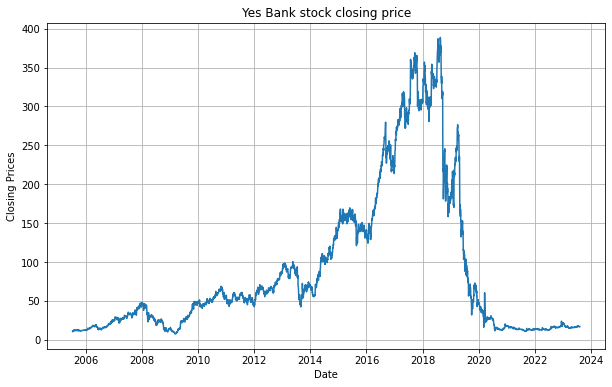

In [56]:
# Plot closing prices
Data_YesBank_ClosePrice = stock_data[['Close']]

plt.figure(figsize=(10,6))
plt.grid()
plt.plot(Data_YesBank_ClosePrice)
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.title('Yes Bank stock closing price')

In [57]:
def create_input_target(df):
    # Rename the 'Close' column to 'Input_1'
    df = df.rename(columns={'Close': 'Input_1'})
    
    # Create shifted columns for the inputs
    df['Input_2'] = df['Input_1'].shift(-1)
    df['Input_3'] = df['Input_2'].shift(-1)
    
    # Create the target column
    df['Target'] = df['Input_3'].shift(-1)
    
    # Drop the last three rows as they will contain NaN values due to shifting
    df = df.iloc[:-3]
    
    # Reset the index
    df = df.reset_index()
    
    return df

# Assuming Data_YesBank_ClosePrice is your DataFrame containing the 'Close' prices
df_actual = create_input_target(Data_YesBank_ClosePrice)
df_actual.head()

,Date,Input_1,Input_2,Input_3,Target
0,2005-07-12 00:00:00+05:30,10.995716,10.607206,10.345190,11.176418
1,2005-07-13 00:00:00+05:30,10.607206,10.345190,11.176418,11.582996
2,2005-07-14 00:00:00+05:30,10.345190,11.176418,11.582996,11.555891
3,2005-07-15 00:00:00+05:30,11.176418,11.582996,11.555891,11.474576
4,2005-07-18 00:00:00+05:30,11.582996,11.555891,11.474576,11.293872


In [58]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(df_actual)

dates.shape, X.shape, y.shape

((4458,), (4458, 3, 1), (4458,))

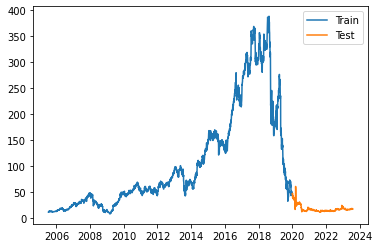

In [59]:
q_80 = int(len(dates) * .8)


dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]


dates_test, X_test, y_test = dates[q_80:], X[q_80:], y[q_80:]

plt.plot(dates_train, y_train)

plt.plot(dates_test, y_test)

plt.legend(['Train',  'Test'])

# Preprocessing again for LSTM 


In [60]:
print(X_train.shape)
print(X_test.shape)


print(y_train.shape)
print(y_test.shape)


(3566, 3, 1)
(892, 3, 1)
(3566,)
(892,)


# Multi-layer LSTM

### c. Implementing the model <a class="anchor" id="section_2_3"></a>

We implement the most simple LSTM model, the "Vanilla LSTM". This model consists in a single hidden layer of LSTM unit, and one output layer used to make predictions.

In [61]:
# ------------------LSTM----------------------
Lstm_MultiLayer_Model = Sequential()
Lstm_MultiLayer_Model.add(LSTM(activation='relu',units=128, return_sequences=True, 
                               input_shape=(X_train.shape[1], X_train.shape[2])))
Lstm_MultiLayer_Model.add(Dropout(0.2))

Lstm_MultiLayer_Model.add(LSTM(activation='relu',units=128, return_sequences=False))
Lstm_MultiLayer_Model.add(Dropout(0.2))

Lstm_MultiLayer_Model.add(Dense(units=1, activation='relu'))
Lstm_MultiLayer_Model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.004), loss='mse', 
                              metrics=[tf.keras.metrics.RootMeanSquaredError()])

Lstm_MultiLayer_Model.summary()

C:\Users\44775\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 3, 128)         │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

### d. Training and evaluating the model <a class="anchor" id="section_1_4"></a>


****************************************************************************************************************

The number of epoch for this experiment is: 10
The Batch Size is: 32
Epoch 1/10
73/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 843.7447 - root_mean_squared_error: 27.2235
Epoch 1: val_loss improved from inf to 303.79367, saving model to best_model_multi_layer_lstm_baseline.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 803.7889 - root_mean_squared_error: 26.5095 - val_loss: 303.7937 - val_root_mean_squared_error: 17.4297
Epoch 2/10
75/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 64.2056 - root_mean_squared_error: 8.0075
Epoch 2: val_loss did not improve from 303.79367
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 64.4723 - root_mean_squared_error: 8.0241 - val_loss: 2315.4207 - val_root_mean_squared_error: 48.1188
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 76.0133 - root_mean_squared_error: 8.7050
Epoch 3: val_loss did not improve from 303.79367
78/78

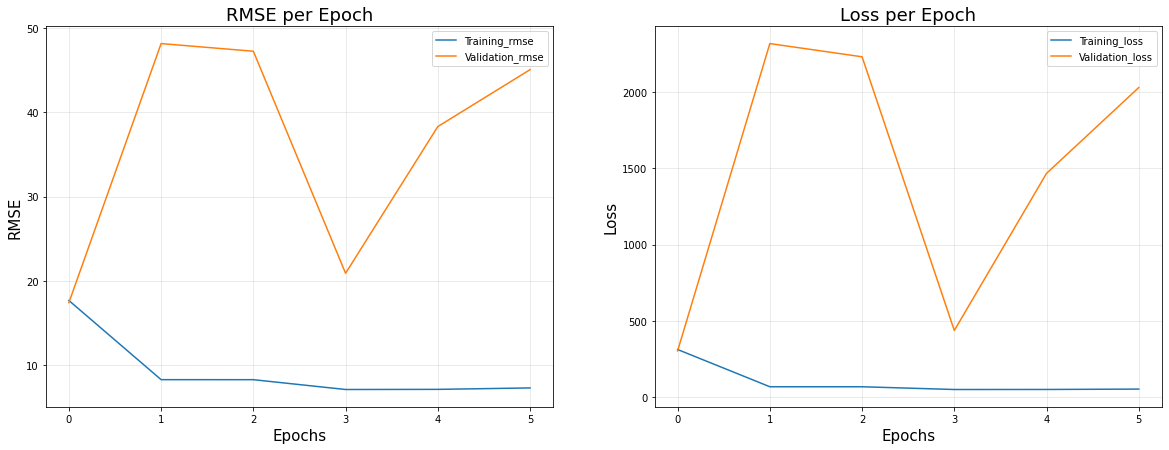

In [65]:
epochs=[10]
batch_sizes = [32]
for epoch in epochs:
    for batch_size in batch_sizes:  
        
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        mc = ModelCheckpoint('best_model_multi_layer_lstm_baseline.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        # fit model
        print()
        print('****************************************************************************************************************')
        print()
        print('The number of epoch for this experiment is:',epoch)
        print('The Batch Size is:',batch_size)
        Lstm_MultiLayer_Model_history = Lstm_MultiLayer_Model.fit(X_train, y_train,validation_split=0.3
                                           ,epochs=epoch, batch_size=batch_size, callbacks=[es,mc])
        print()
        print('****************************************************************************************************************')
        print('The metrics score for epoch: {0}\nBatch Size: {1}\nRMSE for training set: {2}\nRMSE forValidation set: {3}\nLoss for Training set: {4}\nLoss for Validation set: {5}'
              .format(epoch,batch_size,mean(Lstm_MultiLayer_Model_history.history['root_mean_squared_error'])
              ,mean(Lstm_MultiLayer_Model_history.history['val_root_mean_squared_error'])
              ,mean(Lstm_MultiLayer_Model_history.history['loss']), mean(Lstm_MultiLayer_Model_history.history['val_loss'])))
        
       
        
        print('*****************************************************************************************************************')
        print()
        print('*****************************************************************************************************************')
        print()
        print('Comparative plot for RMSE per epoch and Loss per epoch for training and validation sets')
        print('*****************************************************************************************************************')
        print()
        fig = plt.figure(figsize=(20,7))
        fig.add_subplot(121)

        # RMSE per Epoch
        plt.plot(Lstm_MultiLayer_Model_history.epoch, Lstm_MultiLayer_Model_history.history['root_mean_squared_error'], label = "Training_rmse")
        plt.plot(Lstm_MultiLayer_Model_history.epoch, Lstm_MultiLayer_Model_history.history['val_root_mean_squared_error'], label = "Validation_rmse")

        plt.title("RMSE per Epoch", fontsize=18)
        plt.xlabel("Epochs", fontsize=15)
        plt.ylabel("RMSE", fontsize=15)
        plt.grid(alpha=0.3)
        plt.legend()


        #Adding Subplot 1 (For Loss)
        fig.add_subplot(122)

        plt.plot(Lstm_MultiLayer_Model_history.epoch, Lstm_MultiLayer_Model_history.history['loss'], label="Training_loss")
        plt.plot(Lstm_MultiLayer_Model_history.epoch, Lstm_MultiLayer_Model_history.history['val_loss'], label="Validation_loss")

        plt.title("Loss per Epoch", fontsize=18)
        plt.xlabel("Epochs", fontsize=15)
        plt.ylabel("Loss", fontsize=15)
        plt.grid(alpha=0.3)
        plt.legend()

        plt.show()
       
        
       

# Experiment on the Baseline Model Multi-Layer LSTM 
# with different number of epoch and Batch Size


****************************************************************************************************************
****************************************************************************************************************
****************************************************************************************************************
The number of epoch for this experiment is: 10
The Batch Size is: 32
Epoch 1/10
76/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 50.2562 - root_mean_squared_error: 7.0863
Epoch 1: val_loss improved from inf to 2508.29346, saving model to best_model_multi_layer_lstm_experiment.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 50.1764 - root_mean_squared_error: 7.0807 - val_loss: 2508.2935 - val_root_mean_squared_error: 50.0829
Epoch 2/10
72/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 65.0032 - root_mean_squared_error: 8.0492
Epoch 2: val_loss improved from 2508.29346 to 1219.37927, saving model to best_model_multi_layer_lstm_experiment.keras
78/78 ━━━━

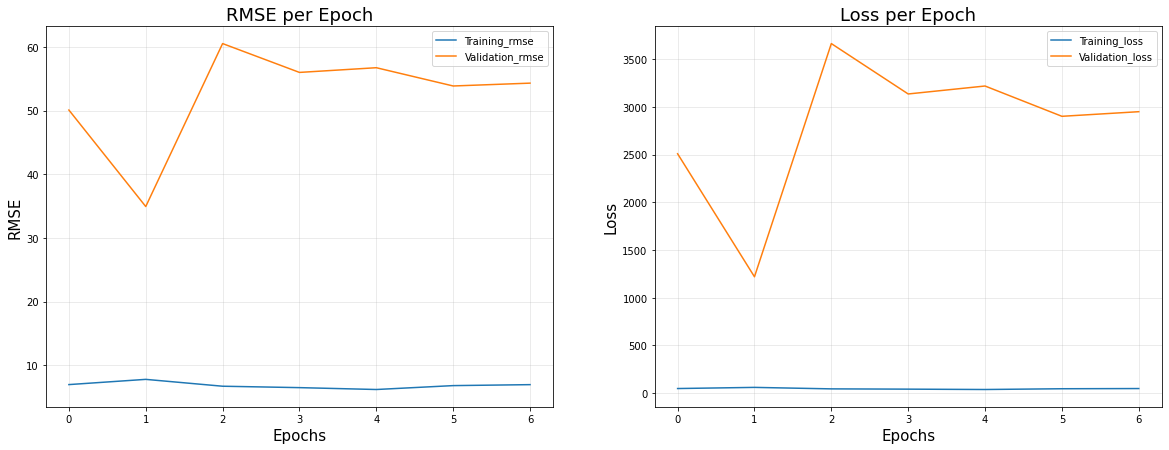


****************************************************************************************************************
****************************************************************************************************************
****************************************************************************************************************
The number of epoch for this experiment is: 10
The Batch Size is: 64
Epoch 1/10
34/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 45.5234 - root_mean_squared_error: 6.7447
Epoch 1: val_loss improved from inf to 3439.46973, saving model to best_model_multi_layer_lstm_experiment.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 45.1527 - root_mean_squared_error: 6.7172 - val_loss: 3439.4697 - val_root_mean_squared_error: 58.6470
Epoch 2/10
33/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 42.2590 - root_mean_squared_error: 6.4768
Epoch 2: val_loss improved from 3439.46973 to 1990.21606, saving model to best_model_multi_layer_lstm_experiment.keras
39/39 ━━━

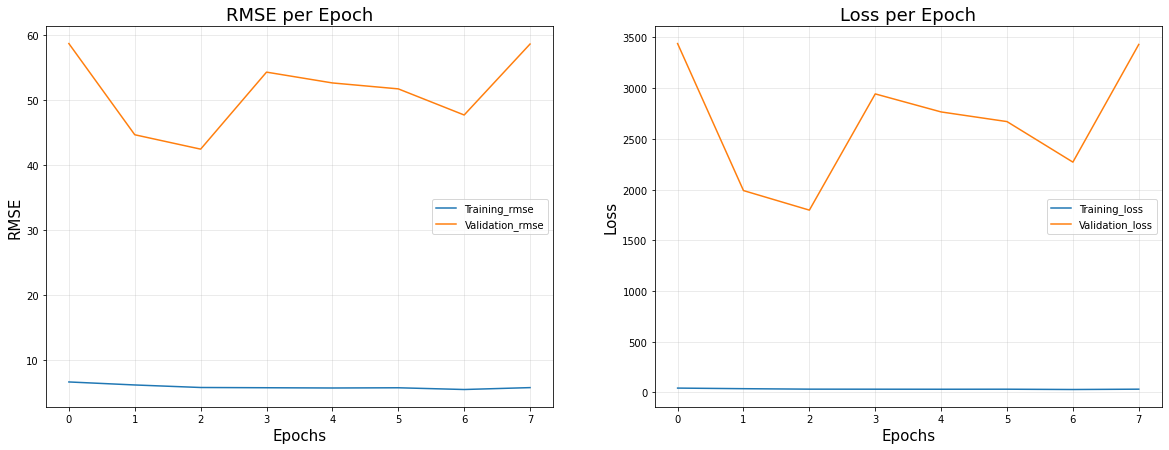


****************************************************************************************************************
****************************************************************************************************************
****************************************************************************************************************
The number of epoch for this experiment is: 10
The Batch Size is: 128
Epoch 1/10
14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 28.9788 - root_mean_squared_error: 5.3825
Epoch 1: val_loss improved from inf to 2887.71436, saving model to best_model_multi_layer_lstm_experiment.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 28.7617 - root_mean_squared_error: 5.3624 - val_loss: 2887.7144 - val_root_mean_squared_error: 53.7375
Epoch 2/10
14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 25.3250 - root_mean_squared_error: 5.0312
Epoch 2: val_loss improved from 2887.71436 to 2764.24536, saving model to best_model_multi_layer_lstm_experiment.keras
20/20 ━━

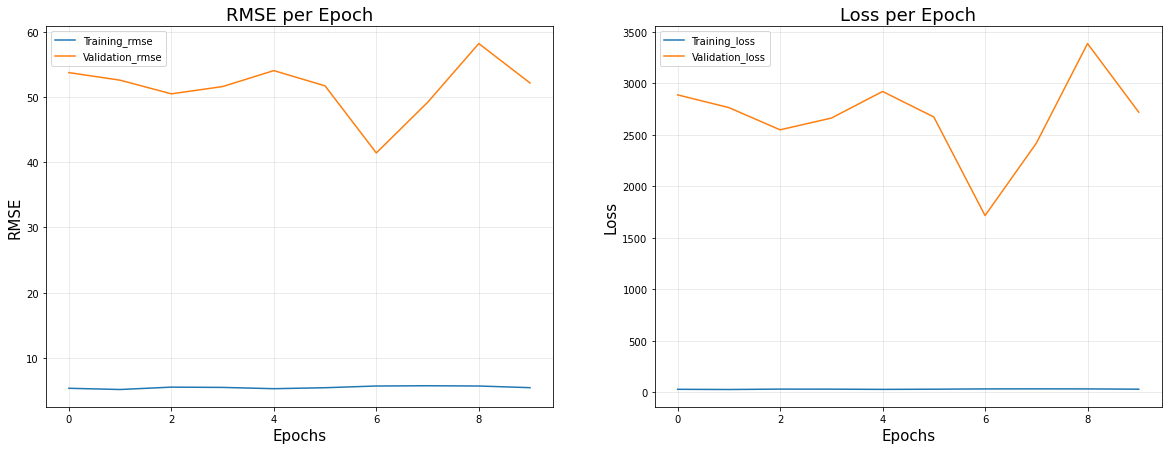


****************************************************************************************************************
****************************************************************************************************************
****************************************************************************************************************
The number of epoch for this experiment is: 10
The Batch Size is: 256
Epoch 1/10
 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 26.6666 - root_mean_squared_error: 5.1631
Epoch 1: val_loss improved from inf to 2583.25464, saving model to best_model_multi_layer_lstm_experiment.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 27.2297 - root_mean_squared_error: 5.2173 - val_loss: 2583.2546 - val_root_mean_squared_error: 50.8257
Epoch 2/10
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 26.2082 - root_mean_squared_error: 5.1181
Epoch 2: val_loss improved from 2583.25464 to 2279.11572, saving model to best_model_multi_layer_lstm_experiment.keras
10/10 

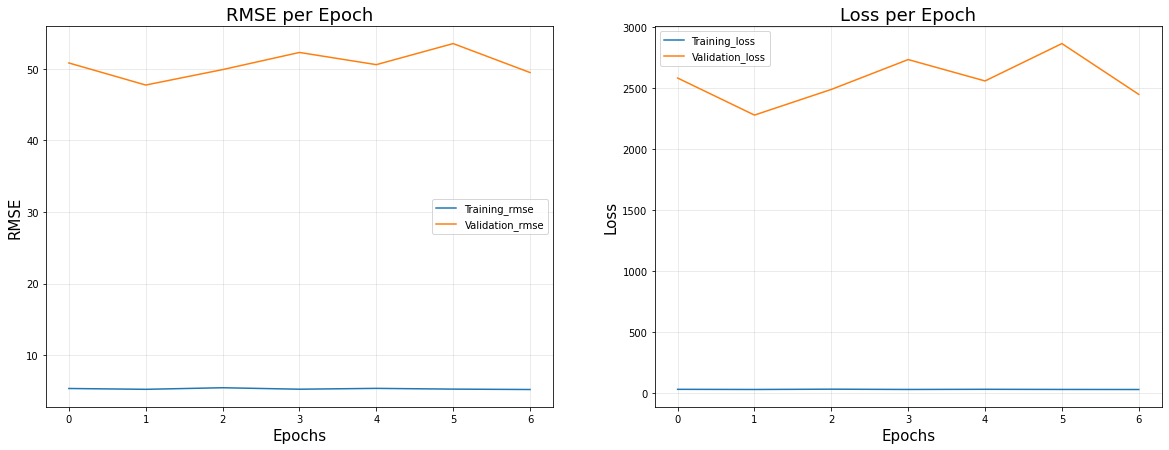


****************************************************************************************************************
****************************************************************************************************************
****************************************************************************************************************
The number of epoch for this experiment is: 20
The Batch Size is: 32
Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 35.6941 - root_mean_squared_error: 5.9601
Epoch 1: val_loss improved from inf to 2423.71313, saving model to best_model_multi_layer_lstm_experiment.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 35.7503 - root_mean_squared_error: 5.9649 - val_loss: 2423.7131 - val_root_mean_squared_error: 49.2312
Epoch 2/20
68/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 39.5223 - root_mean_squared_error: 6.2790
Epoch 2: val_loss improved from 2423.71313 to 1112.83447, saving model to best_model_multi_layer_lstm_experiment.keras
78/78 ━━━━

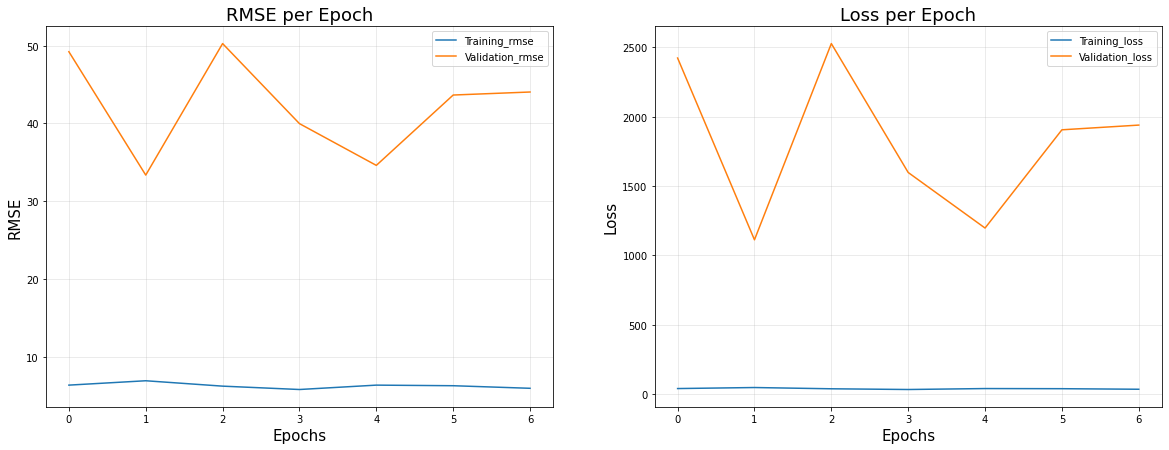


****************************************************************************************************************
****************************************************************************************************************
****************************************************************************************************************
The number of epoch for this experiment is: 20
The Batch Size is: 64
Epoch 1/20
38/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 36.9779 - root_mean_squared_error: 6.0737
Epoch 1: val_loss improved from inf to 2547.45166, saving model to best_model_multi_layer_lstm_experiment.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 36.8691 - root_mean_squared_error: 6.0650 - val_loss: 2547.4517 - val_root_mean_squared_error: 50.4723
Epoch 2/20
35/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 30.4248 - root_mean_squared_error: 5.5103
Epoch 2: val_loss improved from 2547.45166 to 2492.72729, saving model to best_model_multi_layer_lstm_experiment.keras
39/39 ━━━

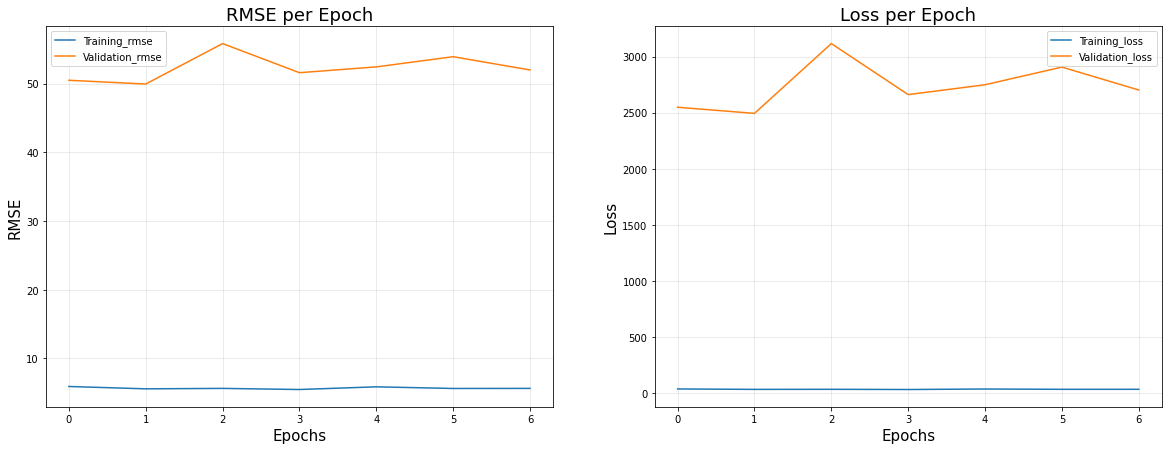


****************************************************************************************************************
****************************************************************************************************************
****************************************************************************************************************
The number of epoch for this experiment is: 20
The Batch Size is: 128
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 28.4807 - root_mean_squared_error: 5.3337
Epoch 1: val_loss improved from inf to 2215.14478, saving model to best_model_multi_layer_lstm_experiment.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 28.5256 - root_mean_squared_error: 5.3381 - val_loss: 2215.1448 - val_root_mean_squared_error: 47.0653
Epoch 2/20
14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 29.7188 - root_mean_squared_error: 5.4441
Epoch 2: val_loss did not improve from 2215.14478
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 29.9237 - root_mean_squared_e

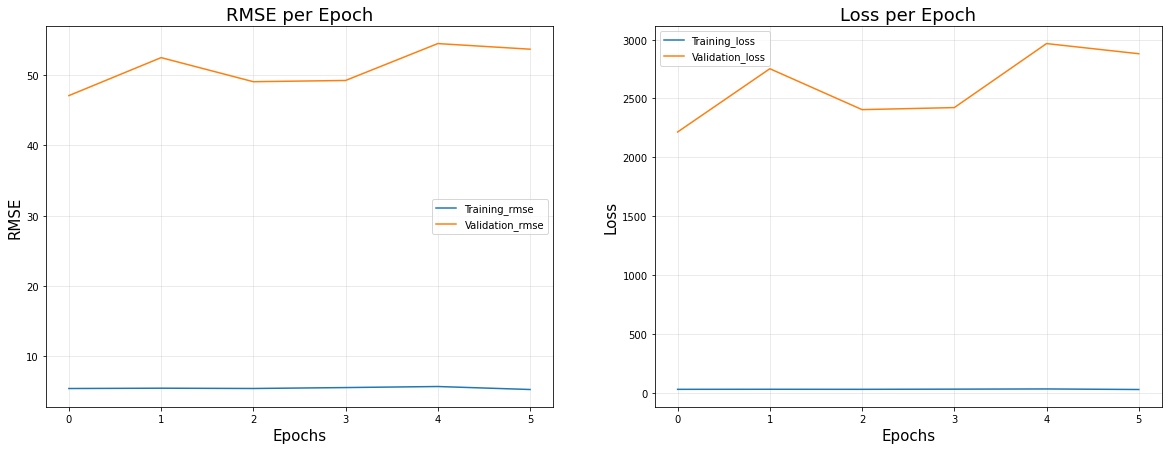


****************************************************************************************************************
****************************************************************************************************************
****************************************************************************************************************
The number of epoch for this experiment is: 20
The Batch Size is: 256
Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 26.3644 - root_mean_squared_error: 5.1316
Epoch 1: val_loss improved from inf to 3122.87354, saving model to best_model_multi_layer_lstm_experiment.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 26.5552 - root_mean_squared_error: 5.1501 - val_loss: 3122.8735 - val_root_mean_squared_error: 55.8827
Epoch 2/20
 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 27.8172 - root_mean_squared_error: 5.2721
Epoch 2: val_loss improved from 3122.87354 to 2560.10083, saving model to best_model_multi_layer_lstm_experiment.keras
10/10 

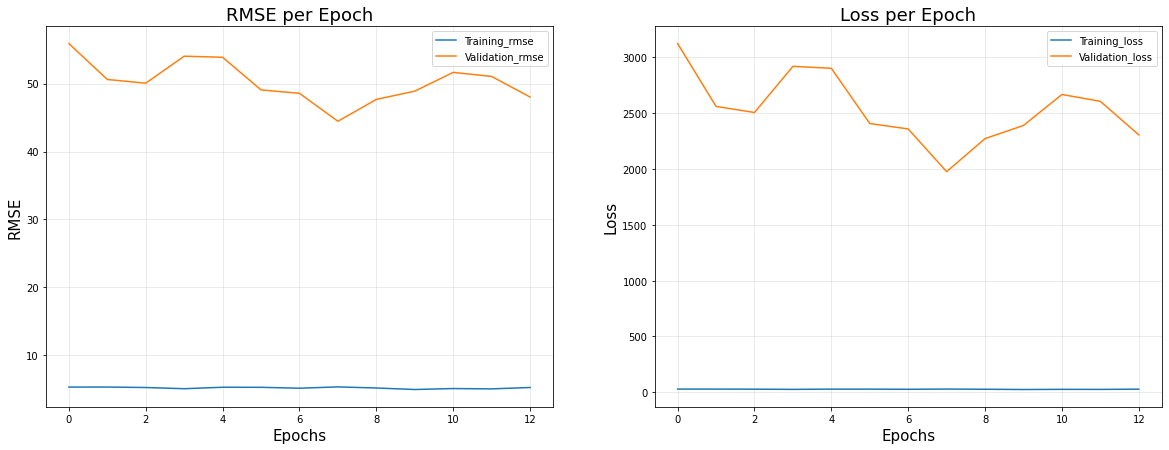


****************************************************************************************************************
****************************************************************************************************************
****************************************************************************************************************
The number of epoch for this experiment is: 50
The Batch Size is: 32
Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 29.1972 - root_mean_squared_error: 5.3958
Epoch 1: val_loss improved from inf to 1809.29541, saving model to best_model_multi_layer_lstm_experiment.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 29.2570 - root_mean_squared_error: 5.4012 - val_loss: 1809.2954 - val_root_mean_squared_error: 42.5358
Epoch 2/50
70/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 32.4792 - root_mean_squared_error: 5.6953
Epoch 2: val_loss did not improve from 1809.29541
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 33.0936 - root_mean_squared_erro

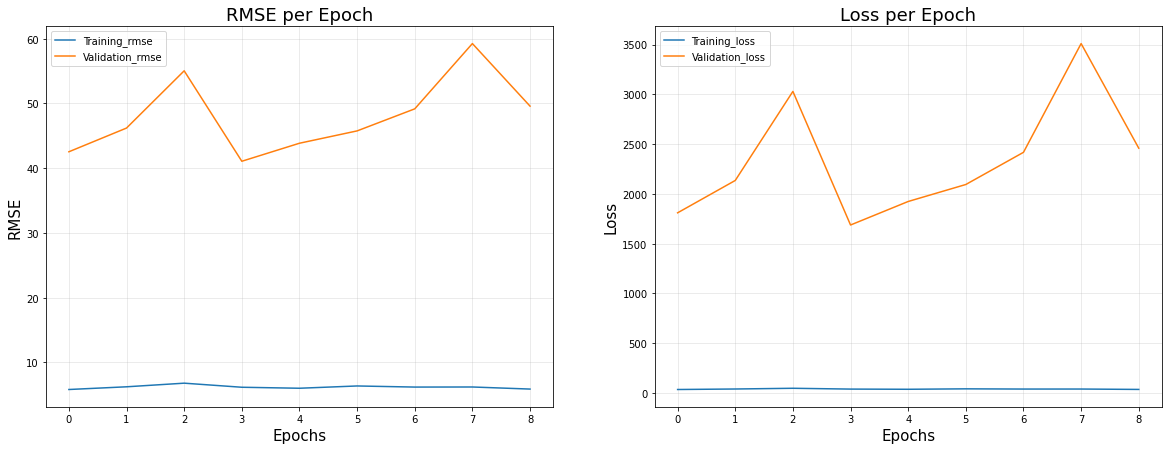


****************************************************************************************************************
****************************************************************************************************************
****************************************************************************************************************
The number of epoch for this experiment is: 50
The Batch Size is: 64
Epoch 1/50
32/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 30.8699 - root_mean_squared_error: 5.5469
Epoch 1: val_loss improved from inf to 3033.30078, saving model to best_model_multi_layer_lstm_experiment.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 31.3465 - root_mean_squared_error: 5.5908 - val_loss: 3033.3008 - val_root_mean_squared_error: 55.0754
Epoch 2/50
33/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 31.3054 - root_mean_squared_error: 5.5895
Epoch 2: val_loss improved from 3033.30078 to 2211.99121, saving model to best_model_multi_layer_lstm_experiment.keras
39/39 ━━━

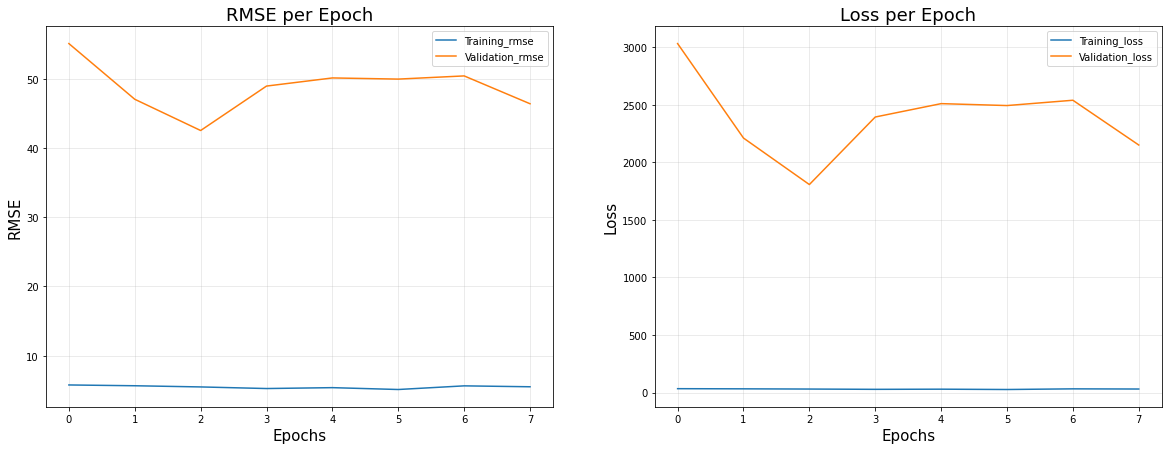


****************************************************************************************************************
****************************************************************************************************************
****************************************************************************************************************
The number of epoch for this experiment is: 50
The Batch Size is: 128
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 31.3031 - root_mean_squared_error: 5.5902
Epoch 1: val_loss improved from inf to 2576.01880, saving model to best_model_multi_layer_lstm_experiment.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 31.1167 - root_mean_squared_error: 5.5733 - val_loss: 2576.0188 - val_root_mean_squared_error: 50.7545
Epoch 2/50
14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 26.6307 - root_mean_squared_error: 5.1593
Epoch 2: val_loss improved from 2576.01880 to 2025.75403, saving model to best_model_multi_layer_lstm_experiment.keras
20/20 ━━

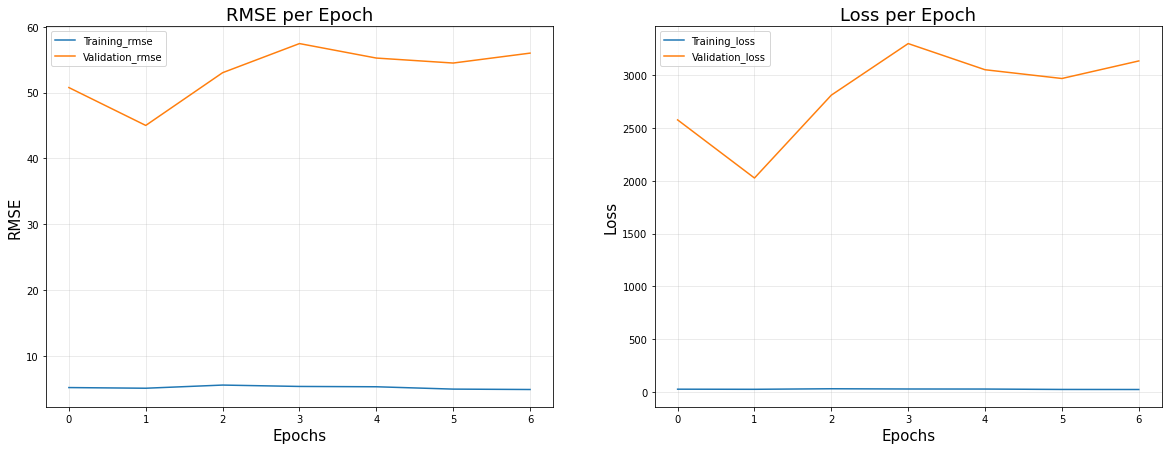


****************************************************************************************************************
****************************************************************************************************************
****************************************************************************************************************
The number of epoch for this experiment is: 50
The Batch Size is: 256
Epoch 1/50
 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 28.8176 - root_mean_squared_error: 5.3667
Epoch 1: val_loss improved from inf to 2589.99048, saving model to best_model_multi_layer_lstm_experiment.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 28.7750 - root_mean_squared_error: 5.3634 - val_loss: 2589.9905 - val_root_mean_squared_error: 50.8919
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 26.0901 - root_mean_squared_error: 5.1061
Epoch 2: val_loss did not improve from 2589.99048
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 26.0480 - root_mean_squared

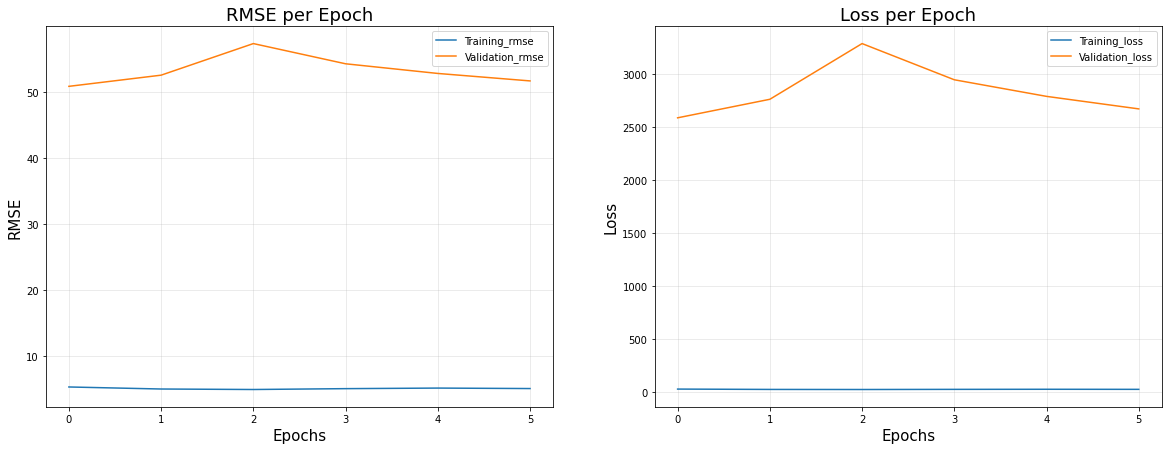


****************************************************************************************************************
****************************************************************************************************************
****************************************************************************************************************
The number of epoch for this experiment is: 100
The Batch Size is: 32
Epoch 1/100
69/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 32.7936 - root_mean_squared_error: 5.7196
Epoch 1: val_loss improved from inf to 1908.98083, saving model to best_model_multi_layer_lstm_experiment.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 32.9983 - root_mean_squared_error: 5.7382 - val_loss: 1908.9808 - val_root_mean_squared_error: 43.6919
Epoch 2/100
76/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 34.5219 - root_mean_squared_error: 5.8538
Epoch 2: val_loss did not improve from 1908.98083
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 34.6722 - root_mean_squared_e

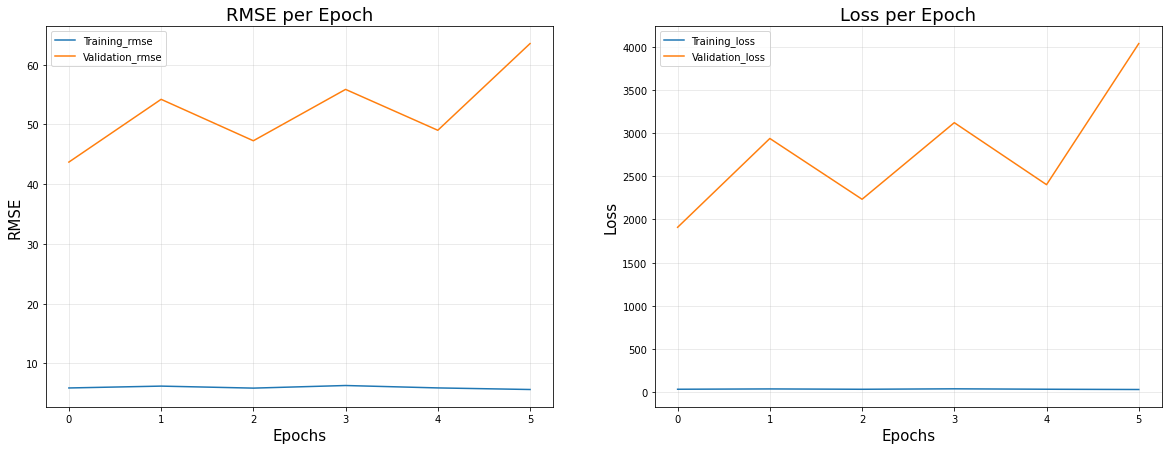


****************************************************************************************************************
****************************************************************************************************************
****************************************************************************************************************
The number of epoch for this experiment is: 100
The Batch Size is: 64
Epoch 1/100
36/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 38.6216 - root_mean_squared_error: 6.1918
Epoch 1: val_loss improved from inf to 2539.40479, saving model to best_model_multi_layer_lstm_experiment.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 38.0936 - root_mean_squared_error: 6.1501 - val_loss: 2539.4048 - val_root_mean_squared_error: 50.3925
Epoch 2/100
35/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 31.1901 - root_mean_squared_error: 5.5686
Epoch 2: val_loss improved from 2539.40479 to 2188.67676, saving model to best_model_multi_layer_lstm_experiment.keras
39/39 

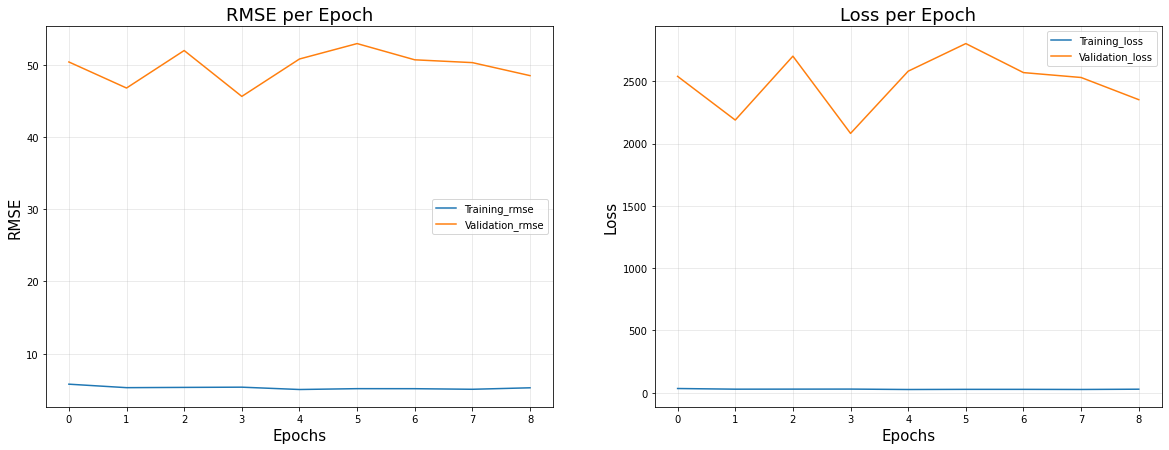


****************************************************************************************************************
****************************************************************************************************************
****************************************************************************************************************
The number of epoch for this experiment is: 100
The Batch Size is: 128
Epoch 1/100
14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 24.6915 - root_mean_squared_error: 4.9684
Epoch 1: val_loss improved from inf to 2364.49512, saving model to best_model_multi_layer_lstm_experiment.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 25.4121 - root_mean_squared_error: 5.0396 - val_loss: 2364.4951 - val_root_mean_squared_error: 48.6261
Epoch 2/100
14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 25.7226 - root_mean_squared_error: 5.0693
Epoch 2: val_loss did not improve from 2364.49512
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 25.5039 - root_mean_square

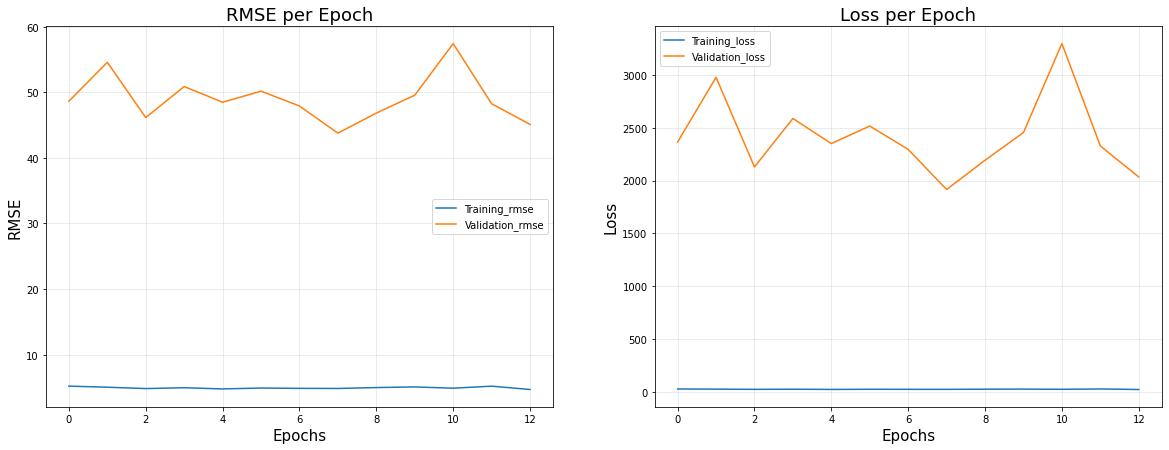


****************************************************************************************************************
****************************************************************************************************************
****************************************************************************************************************
The number of epoch for this experiment is: 100
The Batch Size is: 256
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 24.4692 - root_mean_squared_error: 4.9457
Epoch 1: val_loss improved from inf to 2997.14746, saving model to best_model_multi_layer_lstm_experiment.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 24.4818 - root_mean_squared_error: 4.9471 - val_loss: 2997.1475 - val_root_mean_squared_error: 54.7462
Epoch 2/100
 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 25.5454 - root_mean_squared_error: 5.0538
Epoch 2: val_loss improved from 2997.14746 to 2574.79248, saving model to best_model_multi_layer_lstm_experiment.keras
10/

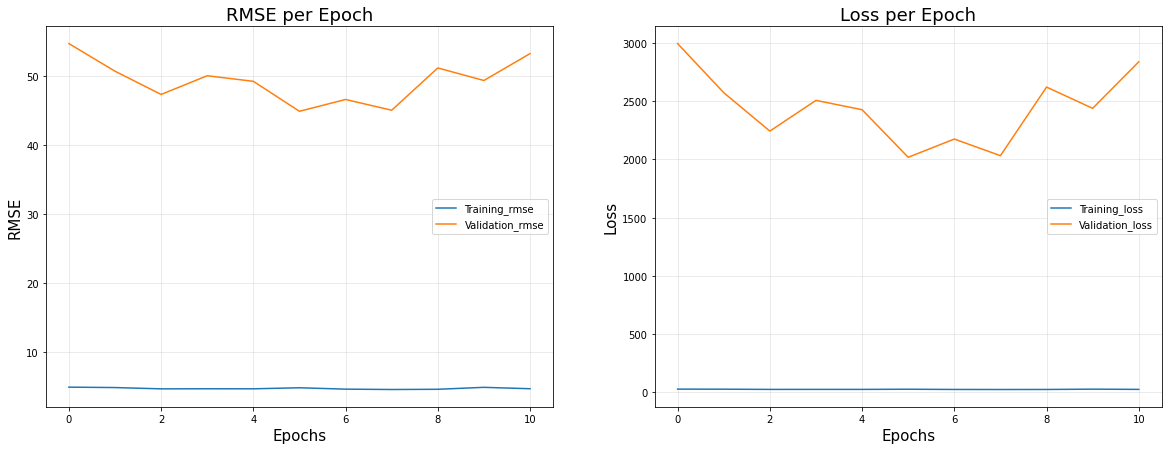

In [66]:
epochs=[10,20,50,100]
batch_sizes = [32,64,128,256]
for epoch in epochs:
    for batch_size in batch_sizes:  
       
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        mc = ModelCheckpoint('best_model_multi_layer_lstm_experiment.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        # fit model
        print()
        print('****************************************************************************************************************')
        print('****************************************************************************************************************')
        print('****************************************************************************************************************')
        print('The number of epoch for this experiment is:',epoch)
        print('The Batch Size is:',batch_size)
        Lstm_MultiLayer_Model_history = Lstm_MultiLayer_Model.fit(X_train, y_train, validation_split=0.3,
                                                                  epochs=epoch, batch_size=batch_size, callbacks=[es,mc])
        
        
        
        print()
        print('****************************************************************************************************************')
        print('The metrics score for epoch: {0}\nBatch Size: {1}\nRMSE for training set: {2}\nRMSE forValidation set: {3}\nLoss for Training set: {4}\nLoss for Validation set: {5}'
              .format(epoch,batch_size,mean(Lstm_MultiLayer_Model_history.history['root_mean_squared_error'])
              ,mean(Lstm_MultiLayer_Model_history.history['val_root_mean_squared_error'])
              ,mean(Lstm_MultiLayer_Model_history.history['loss']), mean(Lstm_MultiLayer_Model_history.history['val_loss'])))
        
       
        
        print('*****************************************************************************************************************')
        print()
        print('*****************************************************************************************************************')
        print()
        print('Comparative plot for RMSE per epoch and Loss per epoch for training and validation sets')
        print('*****************************************************************************************************************')
        print()
        
        fig = plt.figure(figsize=(20,7))
        fig.add_subplot(121)

        # RMSE per Epoch
        plt.plot(Lstm_MultiLayer_Model_history.epoch, Lstm_MultiLayer_Model_history.history['root_mean_squared_error'], label = "Training_rmse")
        plt.plot(Lstm_MultiLayer_Model_history.epoch, Lstm_MultiLayer_Model_history.history['val_root_mean_squared_error'], label = "Validation_rmse")

        plt.title("RMSE per Epoch", fontsize=18)
        plt.xlabel("Epochs", fontsize=15)
        plt.ylabel("RMSE", fontsize=15)
        plt.grid(alpha=0.3)
        plt.legend()


        #Adding Subplot 1 (For Loss)
        fig.add_subplot(122)

        plt.plot(Lstm_MultiLayer_Model_history.epoch, Lstm_MultiLayer_Model_history.history['loss'], label="Training_loss")
        plt.plot(Lstm_MultiLayer_Model_history.epoch, Lstm_MultiLayer_Model_history.history['val_loss'], label="Validation_loss")

        plt.title("Loss per Epoch", fontsize=18)
        plt.xlabel("Epochs", fontsize=15)
        plt.ylabel("Loss", fontsize=15)
        plt.grid(alpha=0.3)
        plt.legend()

        plt.show()
        

## 3. Single-layer LSTM 

### c. Implementing the model <a class="anchor" id="section_3_3"></a>

In [67]:
# ------------------LSTM----------------------
Lstm_SingleLayer_Model = Sequential()
Lstm_SingleLayer_Model.add(LSTM(activation='relu',units=128, return_sequences=True, 
                               input_shape=(X_train.shape[1], X_train.shape[2])))
Lstm_SingleLayer_Model.add(Dropout(0.2))

Lstm_SingleLayer_Model.add(Dense(units=1, activation='relu'))
Lstm_SingleLayer_Model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.004), loss='mse', 
                              metrics=[tf.keras.metrics.RootMeanSquaredError()])

Lstm_SingleLayer_Model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 3, 128)         │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3, 1)           │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,689 (260.50 KB)

 Trainable params: 66,689 (260.50 KB)

 Non-trainable params: 0 (0.00 B)

### d. Training and evaluating the model <a class="anchor" id="section_3_4"></a>

The number of epoch for this experiment is: 10
The Batch Size is: 32
Epoch 1/10
74/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3083.9746 - root_mean_squared_error: 55.1821
Epoch 1: val_loss improved from inf to 20258.83203, saving model to best_model_single_layer_baseline.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3037.1780 - root_mean_squared_error: 54.7542 - val_loss: 20258.8320 - val_root_mean_squared_error: 142.3335
Epoch 2/10
76/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1701.7749 - root_mean_squared_error: 41.2482
Epoch 2: val_loss did not improve from 20258.83203
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1702.0143 - root_mean_squared_error: 41.2512 - val_loss: 23467.1758 - val_root_mean_squared_error: 153.1900
Epoch 3/10
71/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1749.0812 - root_mean_squared_error: 41.7914
Epoch 3: val_loss did not improve from 20258.83203
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1737.4456 - root_mean_squared_error: 41.6530 - val_loss:

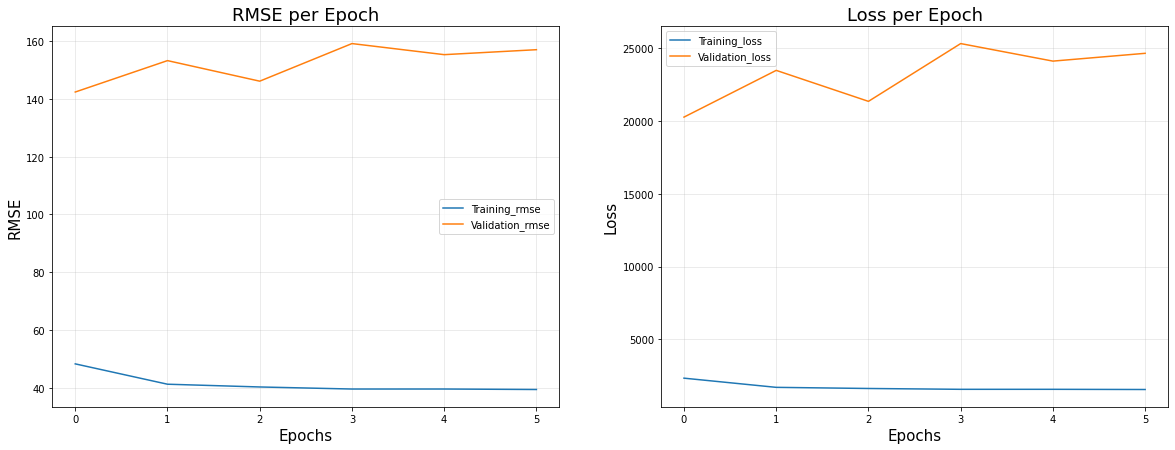

In [68]:
epochs=[10]
batch_sizes = [32]
for epoch in epochs:
    for batch_size in batch_sizes:  
        
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        mc = ModelCheckpoint('best_model_single_layer_baseline.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        # fit model
        print('The number of epoch for this experiment is:',epoch)
        print('The Batch Size is:',batch_size)
        Lstm_SingleLayer_Model_history = Lstm_SingleLayer_Model.fit(X_train, y_train, validation_split=0.3,
                                                                  epochs=epoch, batch_size=batch_size, callbacks=[es,mc])
        
        
        
        print()
        print('****************************************************************************************************************')
        print('The metrics score for epoch: {0}\nBatch Size: {1}\nRMSE for training set: {2}\nRMSE forValidation set: {3}\nLoss for Training set: {4}\nLoss for Validation set: {5}'
              .format(epoch,batch_size,mean(Lstm_SingleLayer_Model_history.history['root_mean_squared_error'])
              ,mean(Lstm_SingleLayer_Model_history.history['val_root_mean_squared_error'])
              ,mean( Lstm_SingleLayer_Model_history.history['loss'])
              ,mean(Lstm_SingleLayer_Model_history.history['val_loss'])))
        
       
        
        print('*****************************************************************************************************************')
        print()
        print('*****************************************************************************************************************')
        print()
        print('Comparative plot for RMSE per epoch and Loss per epoch for training and validation sets')
        print('*****************************************************************************************************************')
        print()
        
        
        
        
        fig = plt.figure(figsize=(20,7))
        fig.add_subplot(121)

        # RMSE per Epoch
        plt.plot(Lstm_SingleLayer_Model_history.epoch, Lstm_SingleLayer_Model_history.history['root_mean_squared_error'], label = "Training_rmse")
        plt.plot(Lstm_SingleLayer_Model_history.epoch, Lstm_SingleLayer_Model_history.history['val_root_mean_squared_error'], label = "Validation_rmse")

        plt.title("RMSE per Epoch", fontsize=18)
        plt.xlabel("Epochs", fontsize=15)
        plt.ylabel("RMSE", fontsize=15)
        plt.grid(alpha=0.3)
        plt.legend()


        #Adding Subplot 1 (For Loss)
        fig.add_subplot(122)

        plt.plot(Lstm_SingleLayer_Model_history.epoch, Lstm_SingleLayer_Model_history.history['loss'], label="Training_loss")
        plt.plot(Lstm_SingleLayer_Model_history.epoch, Lstm_SingleLayer_Model_history.history['val_loss'], label="Validation_loss")

        plt.title("Loss per Epoch", fontsize=18)
        plt.xlabel("Epochs", fontsize=15)
        plt.ylabel("Loss", fontsize=15)
        plt.grid(alpha=0.3)
        plt.legend()

        plt.show()

# Experiment on the Baseline Model Single-Layer LSTM 
# with different number of epoch and Batch Size

*****************************************************************************************************************

*****************************************************************************************************************
*****************************************************************************************************************

*****************************************************************************************************************
The number of epoch for this experiment is: 10
The Batch Size is: 32
Epoch 1/10
69/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1547.9792 - root_mean_squared_error: 39.3331
Epoch 1: val_loss improved from inf to 24637.93555, saving model to best_model_single_layer_lstm_experiment.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1549.9716 - root_mean_squared_error: 39.3597 - val_loss: 24637.9355 - val_root_mean_squared_error: 156.9648
Epoch 2/10
76/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1623.6759 - root_mean_squared_error: 40.274

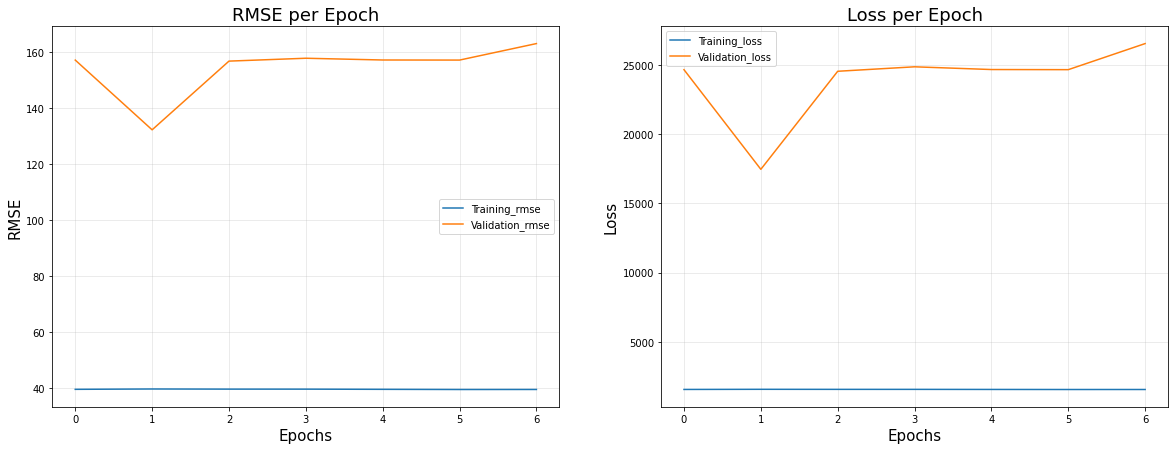

*****************************************************************************************************************

*****************************************************************************************************************
*****************************************************************************************************************

*****************************************************************************************************************
The number of epoch for this experiment is: 10
The Batch Size is: 64
Epoch 1/10
28/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1471.6670 - root_mean_squared_error: 38.3510  
Epoch 1: val_loss improved from inf to 27072.53711, saving model to best_model_single_layer_lstm_experiment.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1489.2805 - root_mean_squared_error: 38.5815 - val_loss: 27072.5371 - val_root_mean_squared_error: 164.5373
Epoch 2/10
30/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1597.6704 - root_mean_squared_error: 39.9

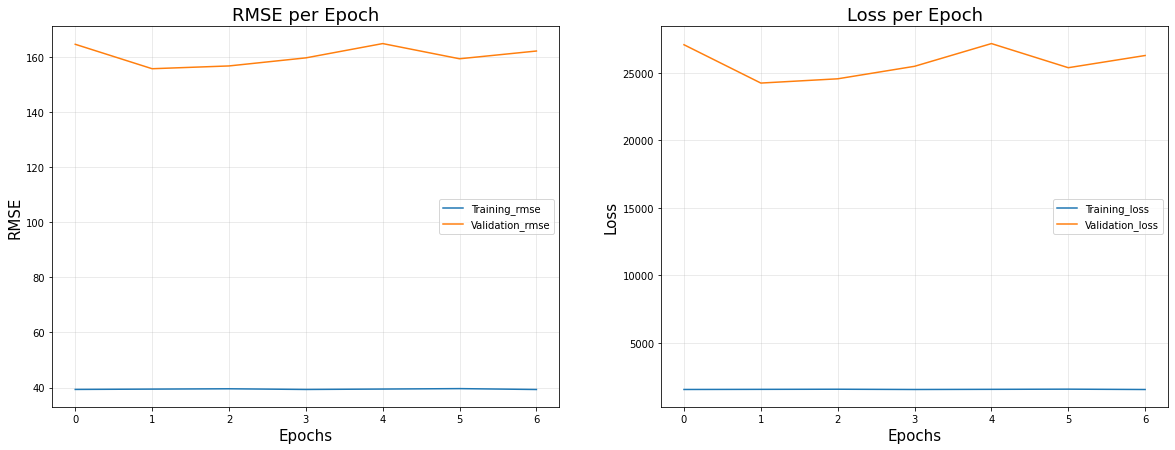

*****************************************************************************************************************

*****************************************************************************************************************
*****************************************************************************************************************

*****************************************************************************************************************
The number of epoch for this experiment is: 10
The Batch Size is: 128
Epoch 1/10
11/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1582.9583 - root_mean_squared_error: 39.7855 
Epoch 1: val_loss improved from inf to 28348.23242, saving model to best_model_single_layer_lstm_experiment.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1566.0057 - root_mean_squared_error: 39.5714 - val_loss: 28348.2324 - val_root_mean_squared_error: 168.3693
Epoch 2/10
12/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1538.4003 - root_mean_squared_error: 39.

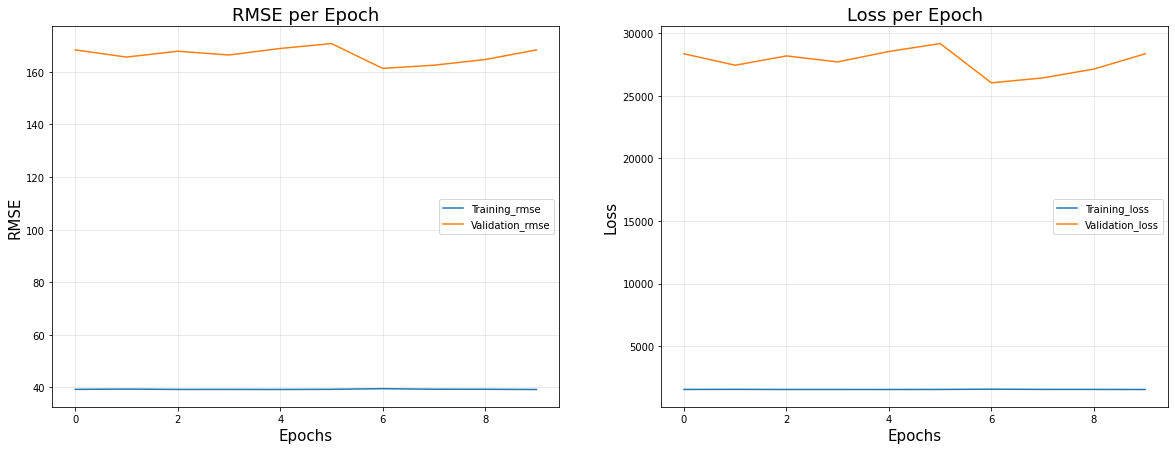

*****************************************************************************************************************

*****************************************************************************************************************
*****************************************************************************************************************

*****************************************************************************************************************
The number of epoch for this experiment is: 10
The Batch Size is: 256
Epoch 1/10
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1471.6532 - root_mean_squared_error: 38.3362 
Epoch 1: val_loss improved from inf to 26504.80469, saving model to best_model_single_layer_lstm_experiment.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1487.0923 - root_mean_squared_error: 38.5393 - val_loss: 26504.8047 - val_root_mean_squared_error: 162.8030
Epoch 2/10
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1569.5416 - root_mean_squared_error: 39.

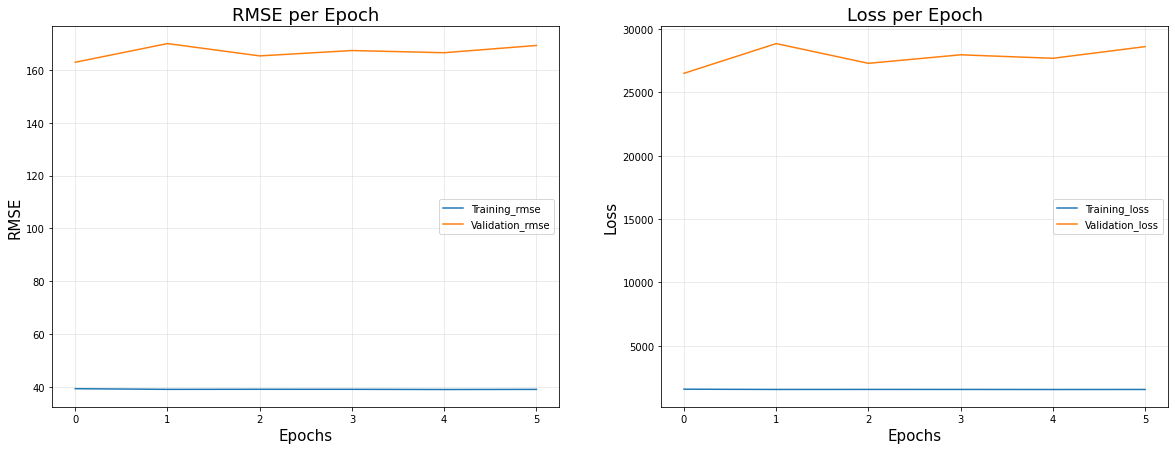

*****************************************************************************************************************

*****************************************************************************************************************
*****************************************************************************************************************

*****************************************************************************************************************
The number of epoch for this experiment is: 20
The Batch Size is: 32
Epoch 1/20
60/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1573.7474 - root_mean_squared_error: 39.6618
Epoch 1: val_loss improved from inf to 25158.09180, saving model to best_model_single_layer_lstm_experiment.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1567.9723 - root_mean_squared_error: 39.5908 - val_loss: 25158.0918 - val_root_mean_squared_error: 158.6130
Epoch 2/20
59/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1580.5897 - root_mean_squared_error: 39.738

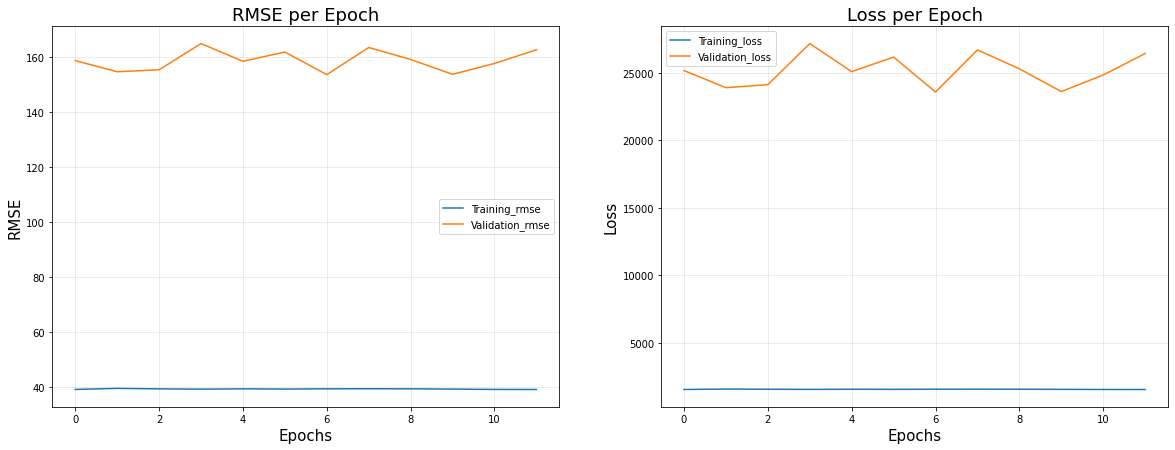

*****************************************************************************************************************

*****************************************************************************************************************
*****************************************************************************************************************

*****************************************************************************************************************
The number of epoch for this experiment is: 20
The Batch Size is: 64
Epoch 1/20
30/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1541.1575 - root_mean_squared_error: 39.2475
Epoch 1: val_loss improved from inf to 26931.63672, saving model to best_model_single_layer_lstm_experiment.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1537.8835 - root_mean_squared_error: 39.2082 - val_loss: 26931.6367 - val_root_mean_squared_error: 164.1086
Epoch 2/20
29/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1655.3856 - root_mean_squared_error: 40.645

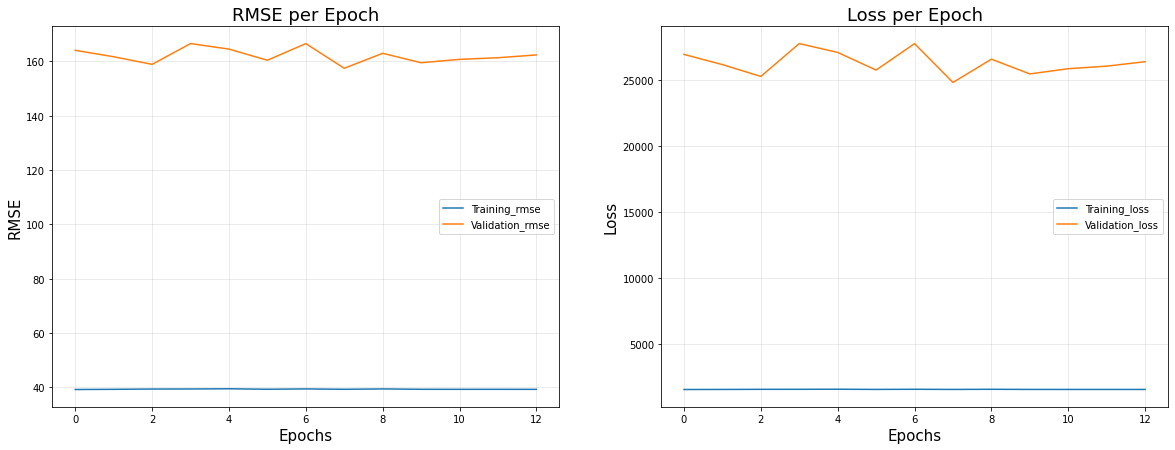

*****************************************************************************************************************

*****************************************************************************************************************
*****************************************************************************************************************

*****************************************************************************************************************
The number of epoch for this experiment is: 20
The Batch Size is: 128
Epoch 1/20
11/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1501.1503 - root_mean_squared_error: 38.7378 
Epoch 1: val_loss improved from inf to 26568.09375, saving model to best_model_single_layer_lstm_experiment.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1503.3080 - root_mean_squared_error: 38.7686 - val_loss: 26568.0938 - val_root_mean_squared_error: 162.9972
Epoch 2/20
12/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1548.7979 - root_mean_squared_error: 39.3

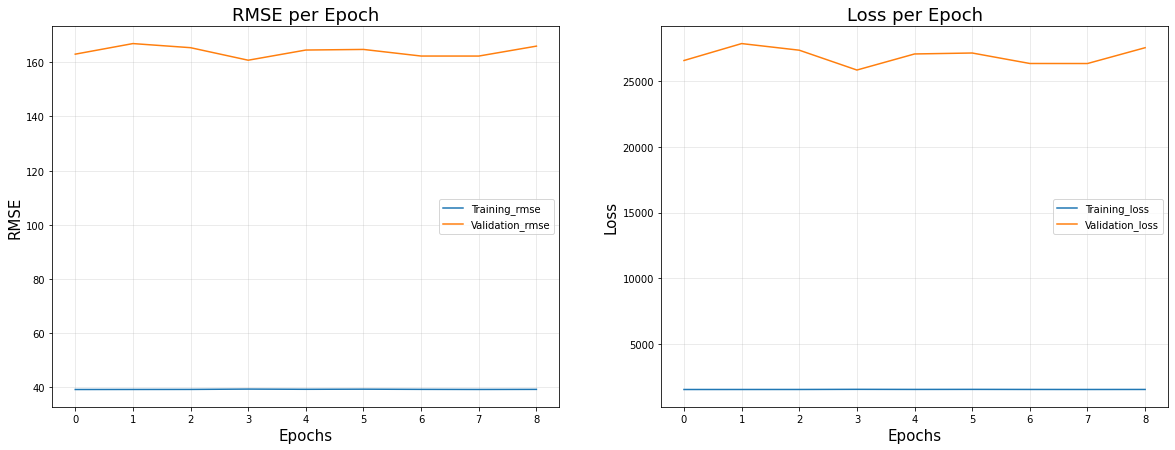

*****************************************************************************************************************

*****************************************************************************************************************
*****************************************************************************************************************

*****************************************************************************************************************
The number of epoch for this experiment is: 20
The Batch Size is: 256
Epoch 1/20
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1605.1299 - root_mean_squared_error: 40.0539 
Epoch 1: val_loss improved from inf to 28065.72656, saving model to best_model_single_layer_lstm_experiment.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1583.5044 - root_mean_squared_error: 39.7833 - val_loss: 28065.7266 - val_root_mean_squared_error: 167.5283
Epoch 2/20
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1469.4897 - root_mean_squared_error: 38.

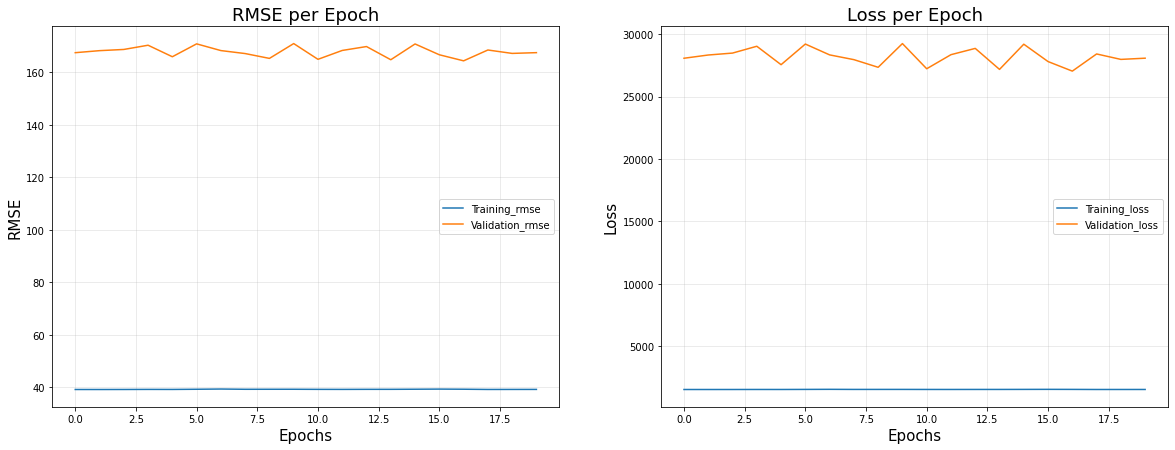

*****************************************************************************************************************

*****************************************************************************************************************
*****************************************************************************************************************

*****************************************************************************************************************
The number of epoch for this experiment is: 50
The Batch Size is: 32
Epoch 1/50
66/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1560.7703 - root_mean_squared_error: 39.5003
Epoch 1: val_loss improved from inf to 24030.91602, saving model to best_model_single_layer_lstm_experiment.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1559.3999 - root_mean_squared_error: 39.4840 - val_loss: 24030.9160 - val_root_mean_squared_error: 155.0191
Epoch 2/50
63/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1556.7882 - root_mean_squared_error: 39.449

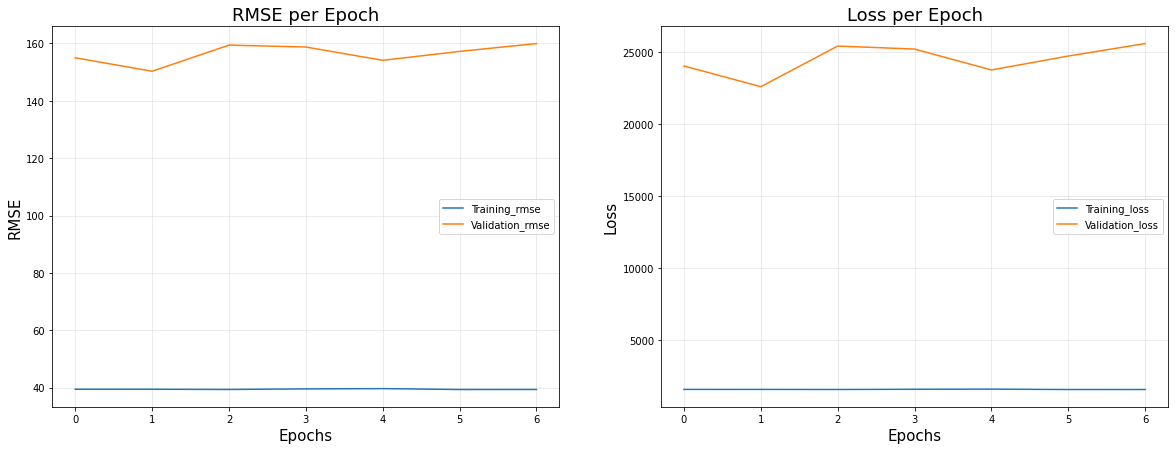

*****************************************************************************************************************

*****************************************************************************************************************
*****************************************************************************************************************

*****************************************************************************************************************
The number of epoch for this experiment is: 50
The Batch Size is: 64
Epoch 1/50
37/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1595.0427 - root_mean_squared_error: 39.9073
Epoch 1: val_loss improved from inf to 23337.58203, saving model to best_model_single_layer_lstm_experiment.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1592.3724 - root_mean_squared_error: 39.8760 - val_loss: 23337.5820 - val_root_mean_squared_error: 152.7664
Epoch 2/50
30/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1511.3469 - root_mean_squared_error: 38.868

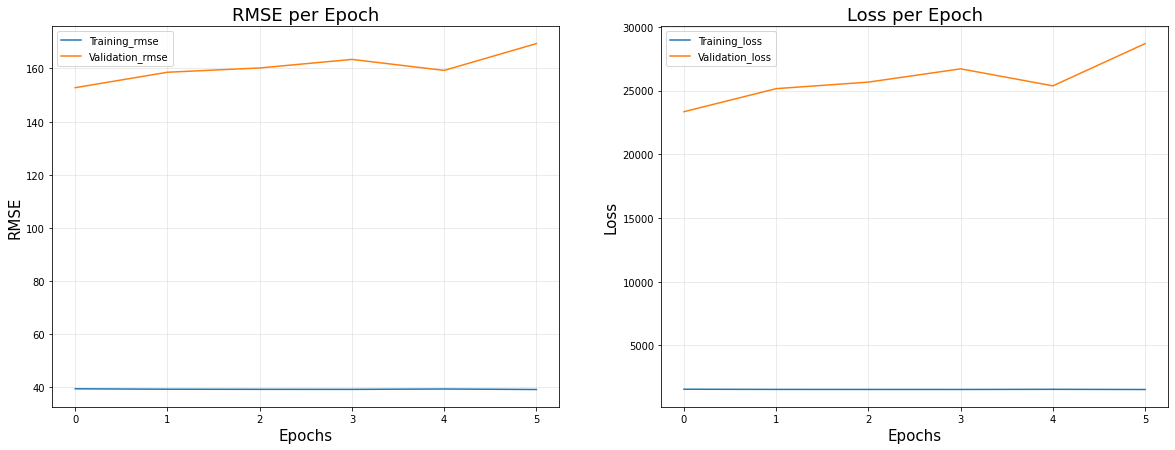

*****************************************************************************************************************

*****************************************************************************************************************
*****************************************************************************************************************

*****************************************************************************************************************
The number of epoch for this experiment is: 50
The Batch Size is: 128
Epoch 1/50
12/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1521.7013 - root_mean_squared_error: 38.9927 
Epoch 1: val_loss improved from inf to 27307.19141, saving model to best_model_single_layer_lstm_experiment.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1539.0223 - root_mean_squared_error: 39.2202 - val_loss: 27307.1914 - val_root_mean_squared_error: 165.2489
Epoch 2/50
12/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1683.5049 - root_mean_squared_error: 41.0

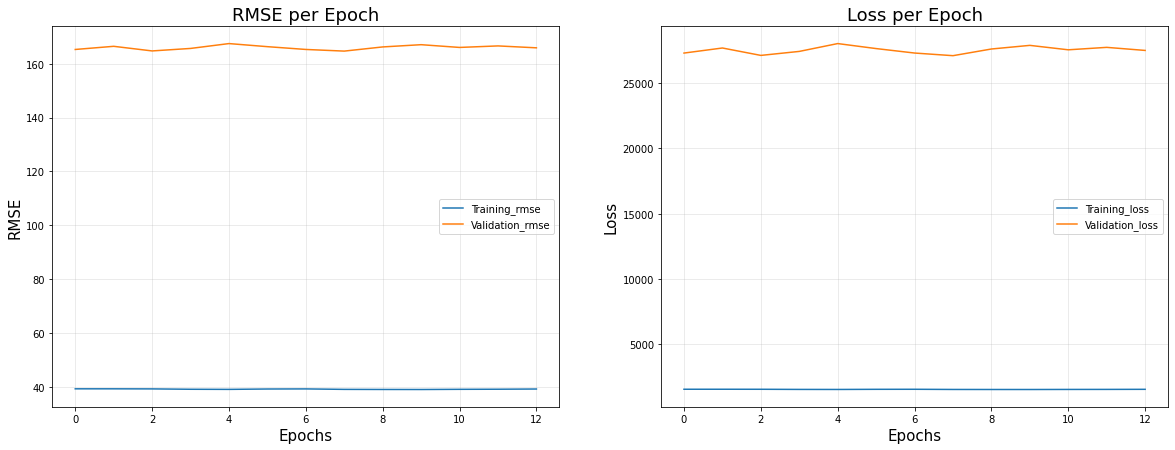

*****************************************************************************************************************

*****************************************************************************************************************
*****************************************************************************************************************

*****************************************************************************************************************
The number of epoch for this experiment is: 50
The Batch Size is: 256
Epoch 1/50
 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1508.8750 - root_mean_squared_error: 38.8361
Epoch 1: val_loss improved from inf to 27119.88477, saving model to best_model_single_layer_lstm_experiment.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1518.4348 - root_mean_squared_error: 38.9616 - val_loss: 27119.8848 - val_root_mean_squared_error: 164.6812
Epoch 2/50
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1545.4281 - root_mean_squared_error: 39.

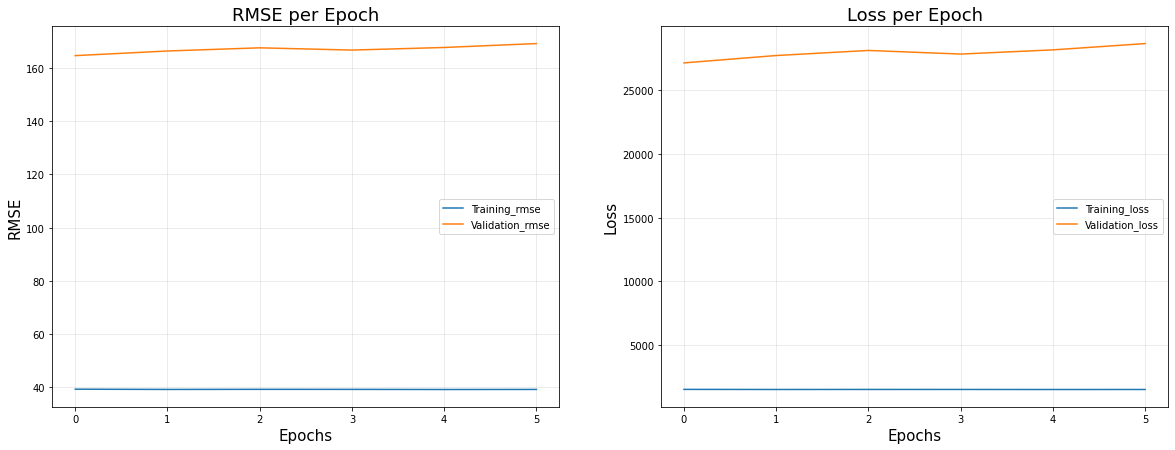

*****************************************************************************************************************

*****************************************************************************************************************
*****************************************************************************************************************

*****************************************************************************************************************
The number of epoch for this experiment is: 100
The Batch Size is: 32
Epoch 1/100
60/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1590.7318 - root_mean_squared_error: 39.8660
Epoch 1: val_loss improved from inf to 24682.81445, saving model to best_model_single_layer_lstm_experiment.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1581.8380 - root_mean_squared_error: 39.7582 - val_loss: 24682.8145 - val_root_mean_squared_error: 157.1077
Epoch 2/100
61/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1482.3915 - root_mean_squared_error: 38.

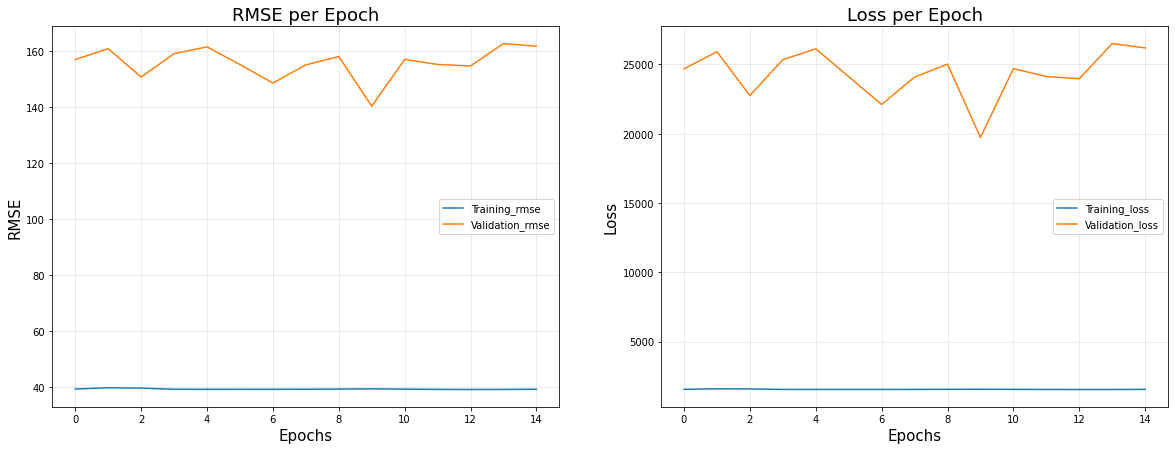

*****************************************************************************************************************

*****************************************************************************************************************
*****************************************************************************************************************

*****************************************************************************************************************
The number of epoch for this experiment is: 100
The Batch Size is: 64
Epoch 1/100
30/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1415.2375 - root_mean_squared_error: 37.6090
Epoch 1: val_loss improved from inf to 26113.99219, saving model to best_model_single_layer_lstm_experiment.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1444.9124 - root_mean_squared_error: 37.9980 - val_loss: 26113.9922 - val_root_mean_squared_error: 161.5982
Epoch 2/100
28/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1523.7338 - root_mean_squared_error: 39.

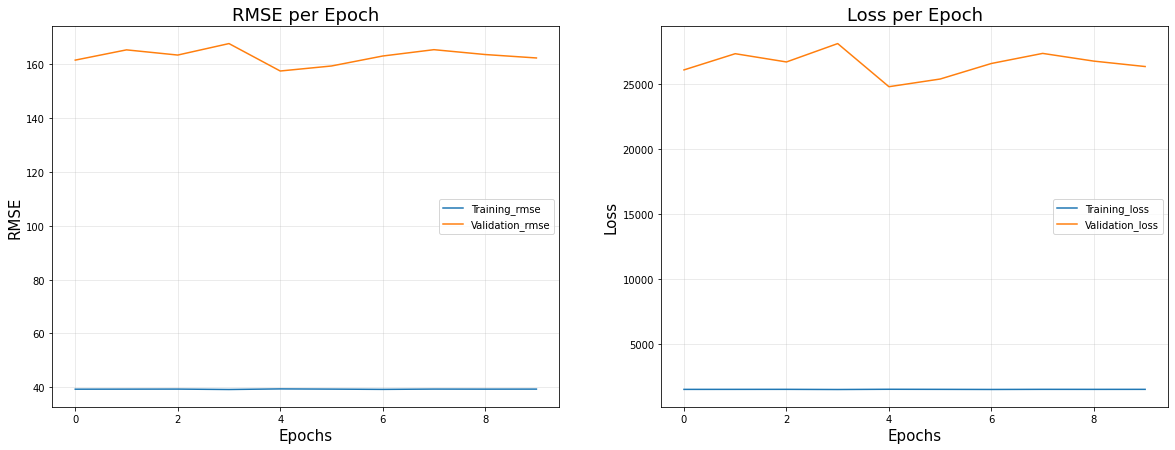

*****************************************************************************************************************

*****************************************************************************************************************
*****************************************************************************************************************

*****************************************************************************************************************
The number of epoch for this experiment is: 100
The Batch Size is: 128
Epoch 1/100
12/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1466.9059 - root_mean_squared_error: 38.2961 
Epoch 1: val_loss improved from inf to 26352.02930, saving model to best_model_single_layer_lstm_experiment.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1506.2478 - root_mean_squared_error: 38.8035 - val_loss: 26352.0293 - val_root_mean_squared_error: 162.3331
Epoch 2/100
13/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1532.7399 - root_mean_squared_error: 

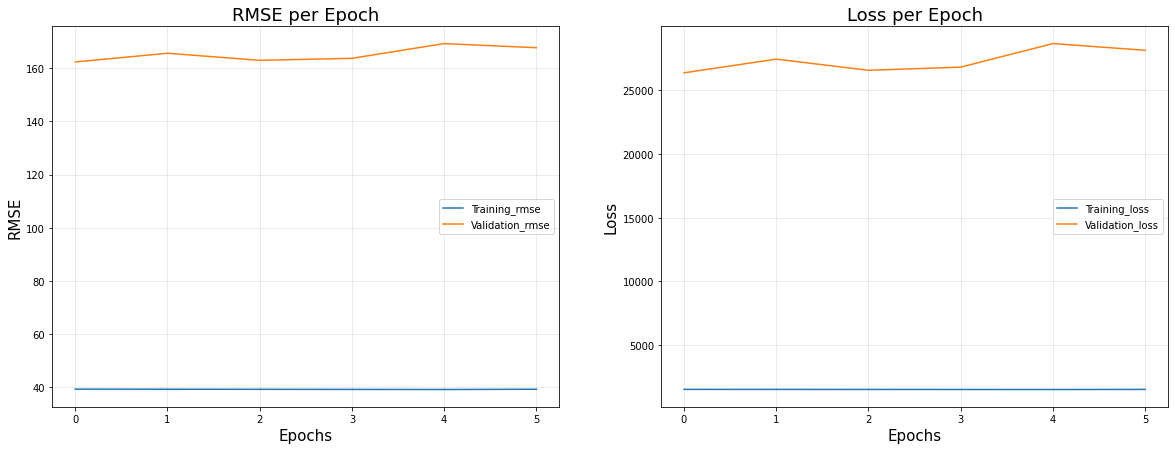

*****************************************************************************************************************

*****************************************************************************************************************
*****************************************************************************************************************

*****************************************************************************************************************
The number of epoch for this experiment is: 100
The Batch Size is: 256
Epoch 1/100
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1560.5504 - root_mean_squared_error: 39.4988 
Epoch 1: val_loss improved from inf to 26208.09180, saving model to best_model_single_layer_lstm_experiment.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1560.4657 - root_mean_squared_error: 39.4986 - val_loss: 26208.0918 - val_root_mean_squared_error: 161.8891
Epoch 2/100
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1605.3994 - root_mean_squared_error: 

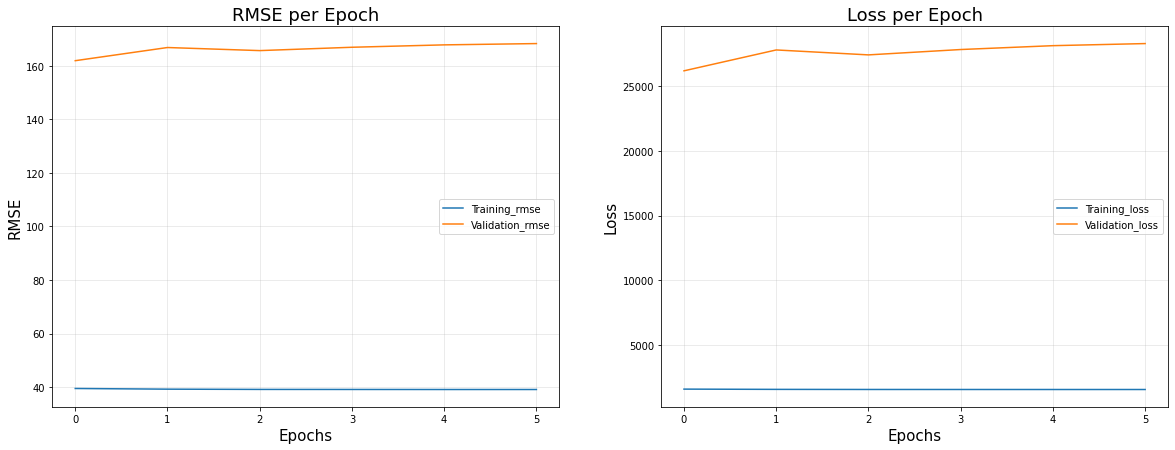

In [69]:
epochs=[10,20,50,100]
batch_sizes = [32,64,128,256]
for epoch in epochs:
    for batch_size in batch_sizes:  
        
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        mc = ModelCheckpoint('best_model_single_layer_lstm_experiment.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        # fit model
        
        print('*****************************************************************************************************************')
        print()
        print('*****************************************************************************************************************')
        print('*****************************************************************************************************************')
        print()
        print('*****************************************************************************************************************')
        print('The number of epoch for this experiment is:',epoch)
        print('The Batch Size is:',batch_size)
        Lstm_SingleLayer_Model_history = Lstm_SingleLayer_Model.fit(X_train, y_train, validation_split=0.3,
                                                                  epochs=epoch, batch_size=batch_size, callbacks=[es,mc])
        
        print()
        print('****************************************************************************************************************')
        print('The metrics score for epoch: {0}\nBatch Size: {1}\nRMSE for training set: {2}\nRMSE forValidation set: {3}\nLoss for Training set: {4}\nLoss for Validation set: {5}'
              .format(epoch,batch_size,mean(Lstm_SingleLayer_Model_history.history['root_mean_squared_error']),
        mean(Lstm_SingleLayer_Model_history.history['val_root_mean_squared_error']),
        mean( Lstm_SingleLayer_Model_history.history['loss']),mean(Lstm_SingleLayer_Model_history.history['val_loss'])))
        
       
        
        print('*****************************************************************************************************************')
        print()
        print('*****************************************************************************************************************')
        print()
        print('Comparative plot for RMSE per epoch and Loss per epoch for training and validation sets')
        print('*****************************************************************************************************************')
        print()
        
        
    
        
        
        fig = plt.figure(figsize=(20,7))
        fig.add_subplot(121)

        # RMSE per Epoch
        plt.plot(Lstm_SingleLayer_Model_history.epoch, Lstm_SingleLayer_Model_history.history['root_mean_squared_error'], label = "Training_rmse")
        plt.plot(Lstm_SingleLayer_Model_history.epoch, Lstm_SingleLayer_Model_history.history['val_root_mean_squared_error'], label = "Validation_rmse")

        plt.title("RMSE per Epoch", fontsize=18)
        plt.xlabel("Epochs", fontsize=15)
        plt.ylabel("RMSE", fontsize=15)
        plt.grid(alpha=0.3)
        plt.legend()


        #Adding Subplot 1 (For Loss)
        fig.add_subplot(122)

        plt.plot(Lstm_SingleLayer_Model_history.epoch, Lstm_SingleLayer_Model_history.history['loss'], label="Training_loss")
        plt.plot(Lstm_SingleLayer_Model_history.epoch, Lstm_SingleLayer_Model_history.history['val_loss'], label="Validation_loss")

        plt.title("Loss per Epoch", fontsize=18)
        plt.xlabel("Epochs", fontsize=15)
        plt.ylabel("Loss", fontsize=15)
        plt.grid(alpha=0.3)
        plt.legend()

        plt.show()

## 3. Bi-directional LSTM 

### c. Implementing the model <a class="anchor" id="section_3_3"></a>

In [70]:
# ------------------LSTM----------------------
Lstm_bidirectional_model = Sequential()
Lstm_bidirectional_model.add(Bidirectional(LSTM(activation='relu',units=128, return_sequences=True), 
                               input_shape=(X_train.shape[1], X_train.shape[2])))
Lstm_bidirectional_model.add(Dropout(0.2))

Lstm_bidirectional_model.add(Bidirectional(LSTM(activation='relu',units=128, return_sequences=False)))
Lstm_bidirectional_model.add(Dropout(0.2))
                                  
Lstm_bidirectional_model.add(Dense(units=1, activation='relu'))
Lstm_bidirectional_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.004), loss='mse', 
                              metrics=[tf.keras.metrics.RootMeanSquaredError()])

Lstm_bidirectional_model.summary()

C:\Users\44775\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 3, 256)         │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 527,617 (2.01 MB)

 Trainable params: 527,617 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

### d. Training and evaluating the model <a class="anchor" id="section_3_4"></a>

*****************************************************************************************************************

*****************************************************************************************************************
The number of epoch for this experiment is: 10
The Batch Size is: 32
Epoch 1/10
75/78 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1176.1512 - root_mean_squared_error: 32.6536
Epoch 1: val_loss improved from inf to 375.12698, saving model to best_model_Bidirectional_layer_baseline.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 1139.4807 - root_mean_squared_error: 32.0766 - val_loss: 375.1270 - val_root_mean_squared_error: 19.3682
Epoch 2/10
76/78 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 69.4492 - root_mean_squared_error: 8.3039
Epoch 2: val_loss did not improve from 375.12698
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 69.1728 - root_mean_squared_error: 8.2880 - val_loss: 776.0994 - val_root_mean_squared_error: 27.8586
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━

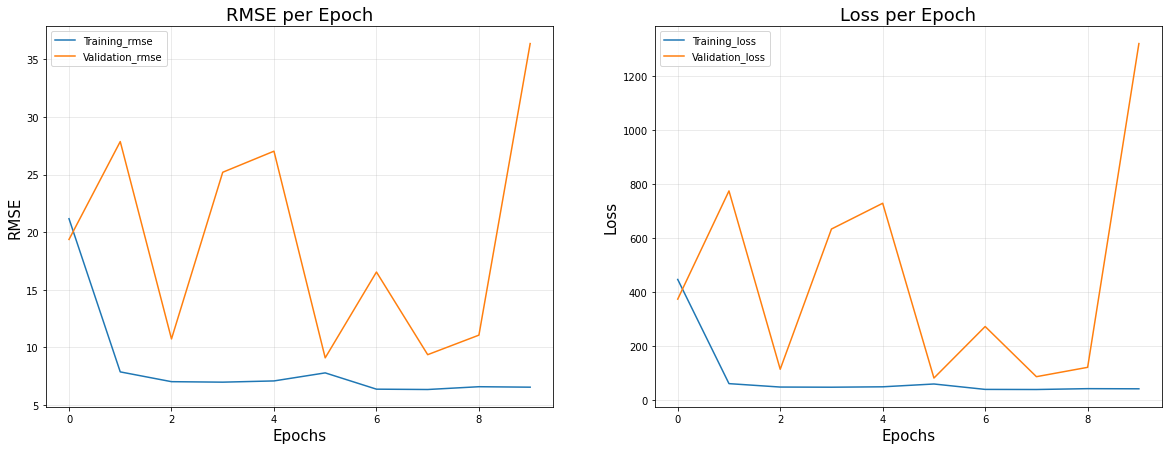

In [71]:
epochs=[10]
batch_sizes = [32]
for epoch in epochs:
    for batch_size in batch_sizes:  
        
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        mc = ModelCheckpoint('best_model_Bidirectional_layer_baseline.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        # fit model
        print('*****************************************************************************************************************')
        print()
        print('*****************************************************************************************************************')
        print('The number of epoch for this experiment is:',epoch)
        print('The Batch Size is:',batch_size)
        Lstm_Bidirectional_Model_history = Lstm_bidirectional_model.fit(X_train, y_train, validation_split=0.3,
                                                                  epochs=epoch, batch_size=batch_size, callbacks=[es,mc])
        
        
        
        
        print()
        print('****************************************************************************************************************')
        print('The metrics score for epoch: {0}\nBatch Size: {1}\nRMSE for training set: {2}\nRMSE forValidation set: {3}\nLoss for Training set: {4}\nLoss for Validation set: {5}'
              .format(epoch,batch_size,mean(Lstm_Bidirectional_Model_history.history['root_mean_squared_error']),
        mean(Lstm_Bidirectional_Model_history.history['val_root_mean_squared_error']),
        mean( Lstm_Bidirectional_Model_history.history['loss']),mean(Lstm_Bidirectional_Model_history.history['val_loss'])))
        
       
        
        print('*****************************************************************************************************************')
        print()
        print('*****************************************************************************************************************')
        print()
        print('Comparative plot for RMSE per epoch and Loss per epoch for training and validation sets')
        print('*****************************************************************************************************************')
        print()
        
       
        
        fig = plt.figure(figsize=(20,7))
        fig.add_subplot(121)

        # RMSE per Epoch
        plt.plot(Lstm_Bidirectional_Model_history.epoch, Lstm_Bidirectional_Model_history.history['root_mean_squared_error'], label = "Training_rmse")
        plt.plot(Lstm_Bidirectional_Model_history.epoch, Lstm_Bidirectional_Model_history.history['val_root_mean_squared_error'], label = "Validation_rmse")

        plt.title("RMSE per Epoch", fontsize=18)
        plt.xlabel("Epochs", fontsize=15)
        plt.ylabel("RMSE", fontsize=15)
        plt.grid(alpha=0.3)
        plt.legend()


        #Adding Subplot 1 (For Loss)
        fig.add_subplot(122)

        plt.plot(Lstm_Bidirectional_Model_history.epoch, Lstm_Bidirectional_Model_history.history['loss'], label="Training_loss")
        plt.plot(Lstm_Bidirectional_Model_history.epoch, Lstm_Bidirectional_Model_history.history['val_loss'], label="Validation_loss")

        plt.title("Loss per Epoch", fontsize=18)
        plt.xlabel("Epochs", fontsize=15)
        plt.ylabel("Loss", fontsize=15)
        plt.grid(alpha=0.3)
        plt.legend()

        plt.show()

# Experiment on the Baseline Model Bi-directional LSTM 
# with different number of epoch and Batch Size

*****************************************************************************************************************

*****************************************************************************************************************

The number of epoch for this experiment is: 10
The Batch Size is: 32
Epoch 1/10
74/78 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 42.9418 - root_mean_squared_error: 6.5313
Epoch 1: val_loss improved from inf to 1328.44666, saving model to best_model_bidirectional_lstm_experiment.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 42.6015 - root_mean_squared_error: 6.5058 - val_loss: 1328.4467 - val_root_mean_squared_error: 36.4479
Epoch 2/10
73/78 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 39.4739 - root_mean_squared_error: 6.2813
Epoch 2: val_loss improved from 1328.44666 to 574.49097, saving model to best_model_bidirectional_lstm_experiment.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 39.3245 - root_mean_squared_error: 6.2694 - val_loss: 574.4910 - val_

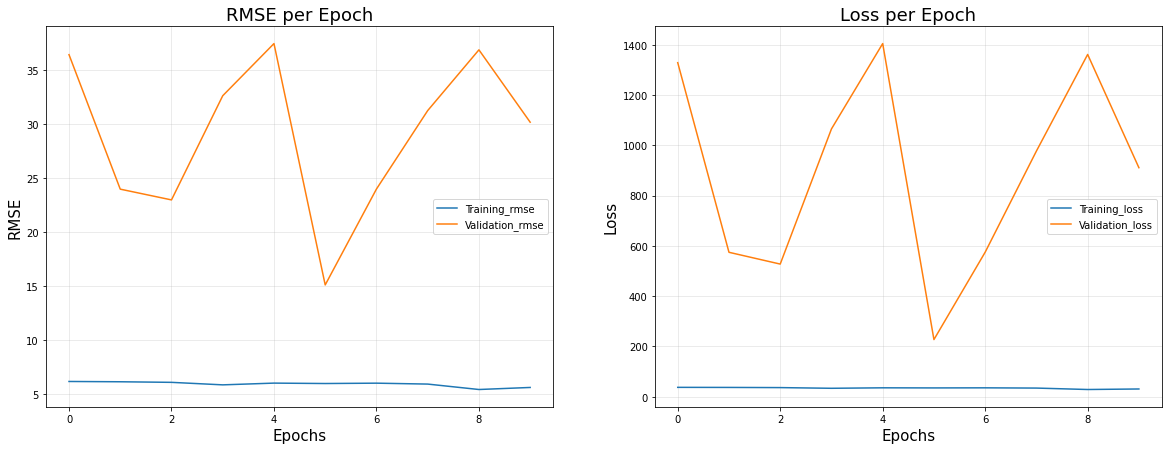

*****************************************************************************************************************

*****************************************************************************************************************

The number of epoch for this experiment is: 10
The Batch Size is: 64
Epoch 1/10
35/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 28.5302 - root_mean_squared_error: 5.3403
Epoch 1: val_loss improved from inf to 1321.78857, saving model to best_model_bidirectional_lstm_experiment.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 28.4520 - root_mean_squared_error: 5.3331 - val_loss: 1321.7886 - val_root_mean_squared_error: 36.3564
Epoch 2/10
36/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 24.4023 - root_mean_squared_error: 4.9316
Epoch 2: val_loss improved from 1321.78857 to 757.07056, saving model to best_model_bidirectional_lstm_experiment.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 24.5495 - root_mean_squared_error: 4.9471 - val_loss: 757.0706 - v

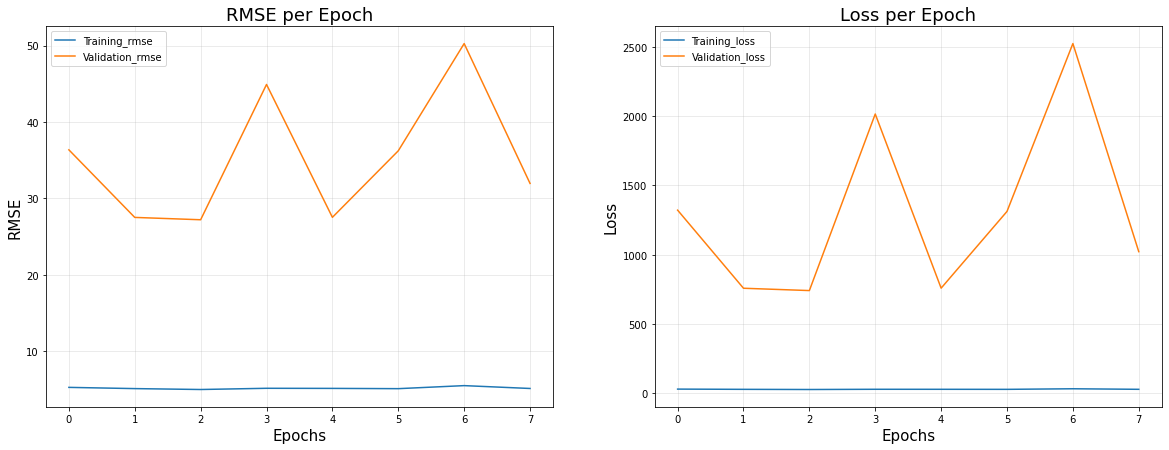

*****************************************************************************************************************

*****************************************************************************************************************

The number of epoch for this experiment is: 10
The Batch Size is: 128
Epoch 1/10
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 23.7644 - root_mean_squared_error: 4.8721
Epoch 1: val_loss improved from inf to 1516.65076, saving model to best_model_bidirectional_lstm_experiment.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 23.6771 - root_mean_squared_error: 4.8636 - val_loss: 1516.6508 - val_root_mean_squared_error: 38.9442
Epoch 2/10
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 26.5430 - root_mean_squared_error: 5.1481
Epoch 2: val_loss did not improve from 1516.65076
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 26.0165 - root_mean_squared_error: 5.0963 - val_loss: 1633.6427 - val_root_mean_squared_error: 40.4183
Epoch 3/10
17/20 ━━━━━━━━━━━━━━━

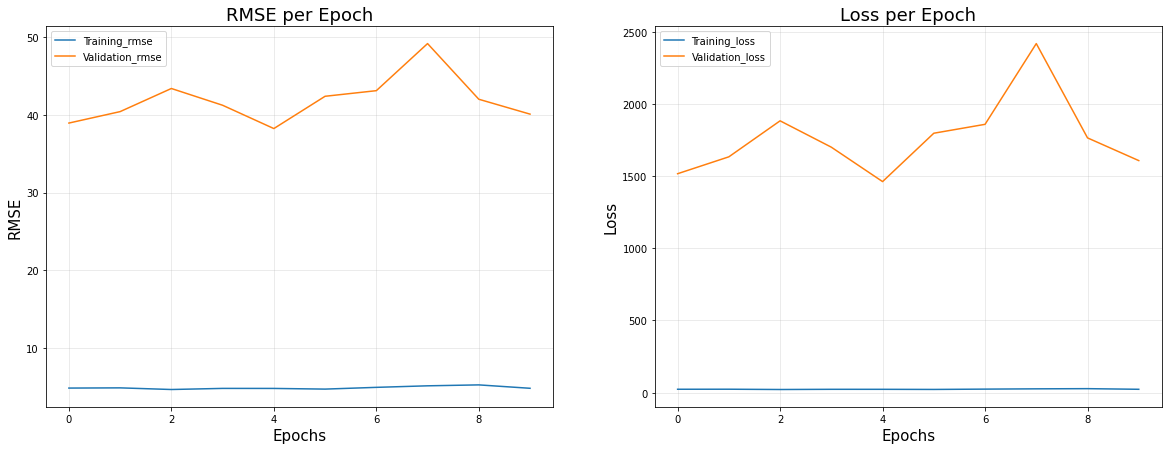

*****************************************************************************************************************

*****************************************************************************************************************

The number of epoch for this experiment is: 10
The Batch Size is: 256
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 23.7397 - root_mean_squared_error: 4.8718
Epoch 1: val_loss improved from inf to 2283.21338, saving model to best_model_bidirectional_lstm_experiment.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 23.7003 - root_mean_squared_error: 4.8678 - val_loss: 2283.2134 - val_root_mean_squared_error: 47.7830
Epoch 2/10
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 21.2298 - root_mean_squared_error: 4.6066
Epoch 2: val_loss improved from 2283.21338 to 2094.79834, saving model to best_model_bidirectional_lstm_experiment.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 20.8256 - root_mean_squared_error: 4.5622 - val_loss: 2094.7983 

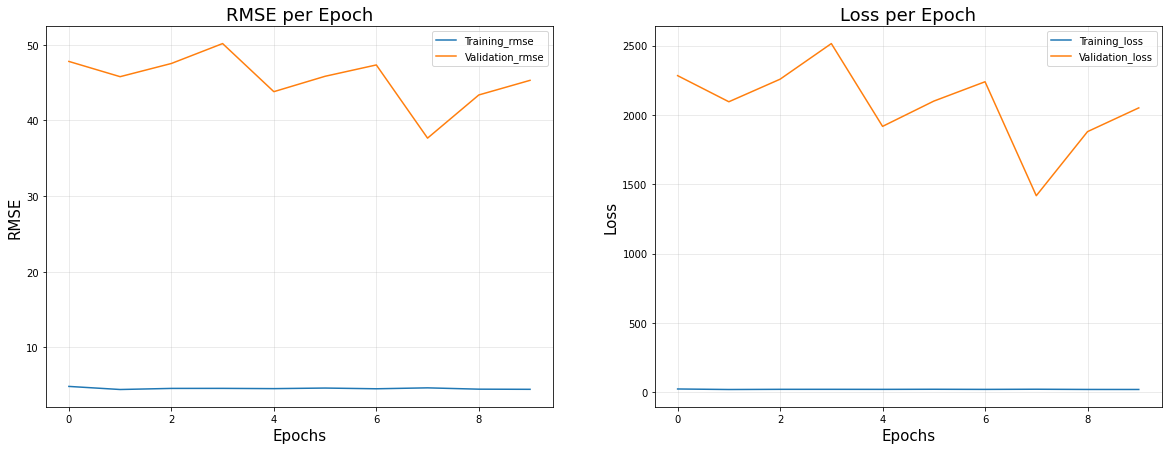

*****************************************************************************************************************

*****************************************************************************************************************

The number of epoch for this experiment is: 20
The Batch Size is: 32
Epoch 1/20
72/78 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 28.9178 - root_mean_squared_error: 5.3577
Epoch 1: val_loss improved from inf to 1521.40601, saving model to best_model_bidirectional_lstm_experiment.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 29.2816 - root_mean_squared_error: 5.3922 - val_loss: 1521.4060 - val_root_mean_squared_error: 39.0052
Epoch 2/20
72/78 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 30.7729 - root_mean_squared_error: 5.5287
Epoch 2: val_loss improved from 1521.40601 to 1086.90344, saving model to best_model_bidirectional_lstm_experiment.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 30.6773 - root_mean_squared_error: 5.5216 - val_loss: 1086.9034 - va

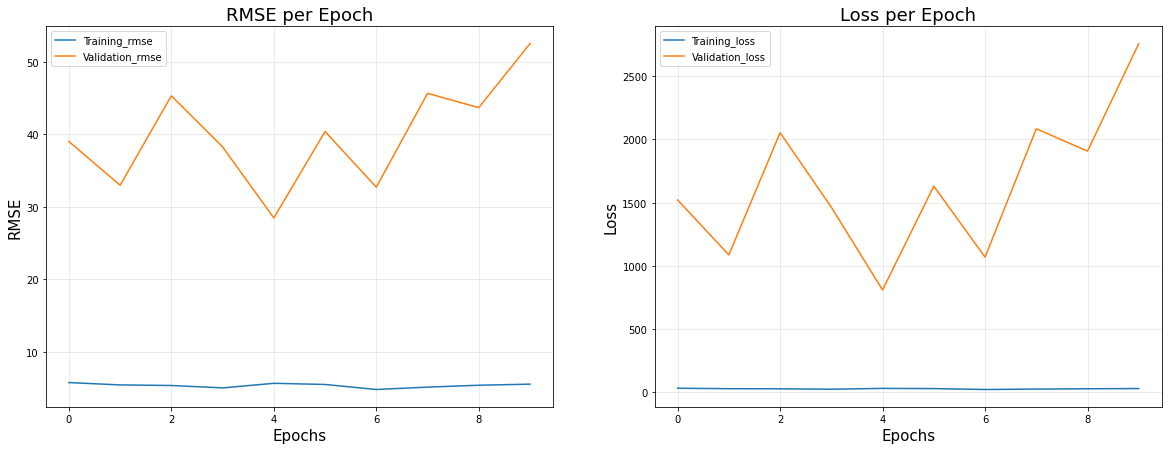

*****************************************************************************************************************

*****************************************************************************************************************

The number of epoch for this experiment is: 20
The Batch Size is: 64
Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 26.5217 - root_mean_squared_error: 5.1400
Epoch 1: val_loss improved from inf to 2005.09998, saving model to best_model_bidirectional_lstm_experiment.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 26.4581 - root_mean_squared_error: 5.1339 - val_loss: 2005.1000 - val_root_mean_squared_error: 44.7783
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 25.5600 - root_mean_squared_error: 5.0516
Epoch 2: val_loss improved from 2005.09998 to 1841.18958, saving model to best_model_bidirectional_lstm_experiment.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 25.5182 - root_mean_squared_error: 5.0475 - val_loss: 1841.1896 -

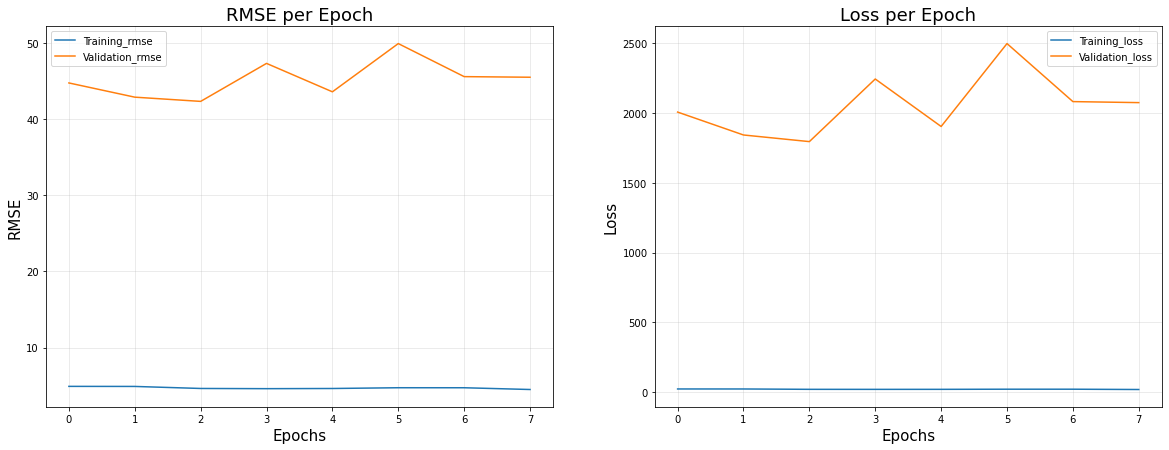

*****************************************************************************************************************

*****************************************************************************************************************

The number of epoch for this experiment is: 20
The Batch Size is: 128
Epoch 1/20
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 20.5893 - root_mean_squared_error: 4.5358
Epoch 1: val_loss improved from inf to 2368.96802, saving model to best_model_bidirectional_lstm_experiment.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 20.4523 - root_mean_squared_error: 4.5209 - val_loss: 2368.9680 - val_root_mean_squared_error: 48.6720
Epoch 2/20
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 21.8033 - root_mean_squared_error: 4.6667
Epoch 2: val_loss improved from 2368.96802 to 2023.19250, saving model to best_model_bidirectional_lstm_experiment.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 21.5445 - root_mean_squared_error: 4.6390 - val_loss: 2023.1925 

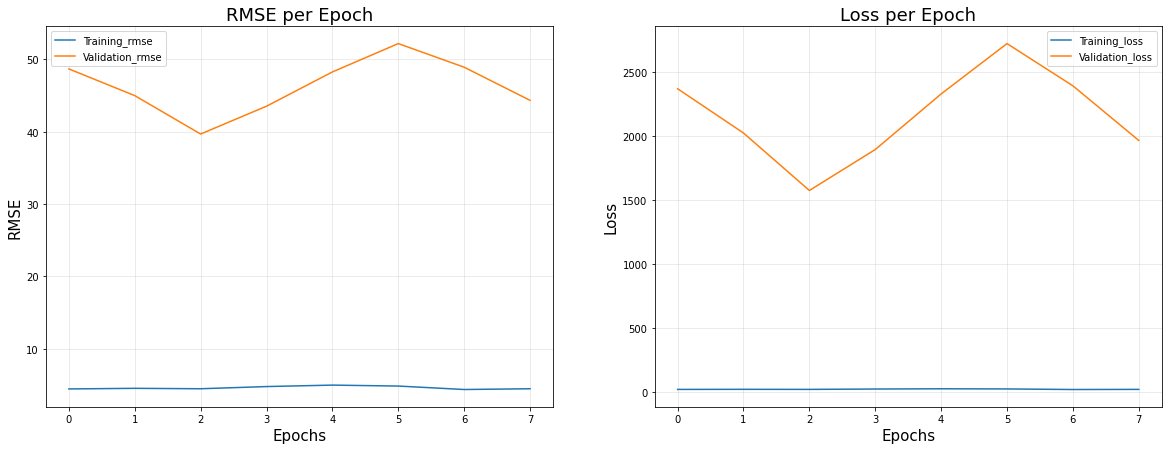

*****************************************************************************************************************

*****************************************************************************************************************

The number of epoch for this experiment is: 20
The Batch Size is: 256
Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 17.8783 - root_mean_squared_error: 4.2251
Epoch 1: val_loss improved from inf to 2029.71777, saving model to best_model_bidirectional_lstm_experiment.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 17.9414 - root_mean_squared_error: 4.2328 - val_loss: 2029.7178 - val_root_mean_squared_error: 45.0524
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 20.7289 - root_mean_squared_error: 4.5520
Epoch 2: val_loss did not improve from 2029.71777
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 20.6697 - root_mean_squared_error: 4.5455 - val_loss: 2049.1863 - val_root_mean_squared_error: 45.2679
Epoch 3/20
 9/10 ━━━━━━━━━━━━━━━

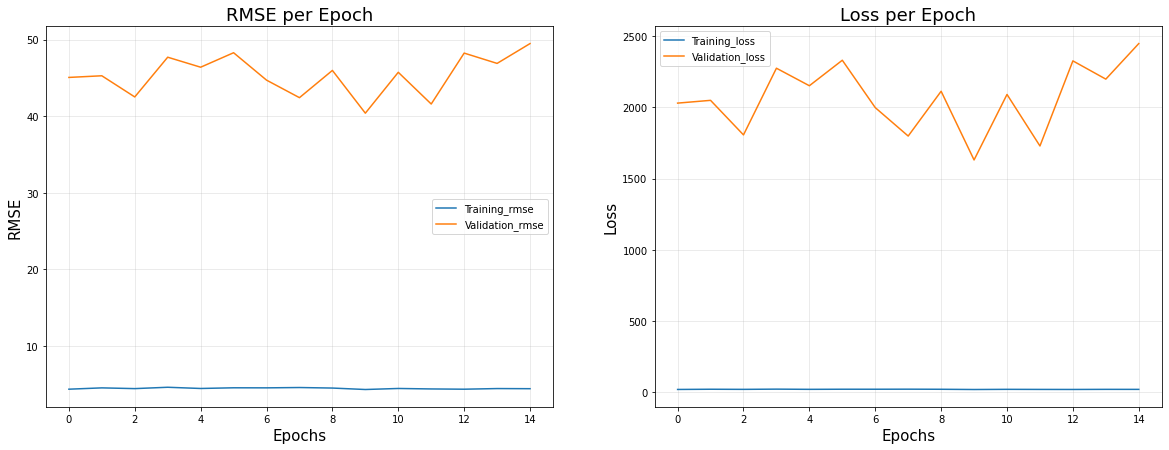

*****************************************************************************************************************

*****************************************************************************************************************

The number of epoch for this experiment is: 50
The Batch Size is: 32
Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 32.0653 - root_mean_squared_error: 5.6482
Epoch 1: val_loss improved from inf to 1304.82397, saving model to best_model_bidirectional_lstm_experiment.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 32.1029 - root_mean_squared_error: 5.6516 - val_loss: 1304.8240 - val_root_mean_squared_error: 36.1223
Epoch 2/50
76/78 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 28.4576 - root_mean_squared_error: 5.3307
Epoch 2: val_loss did not improve from 1304.82397
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 28.5086 - root_mean_squared_error: 5.3355 - val_loss: 1500.9625 - val_root_mean_squared_error: 38.7423
Epoch 3/50
77/78 ━━━━━━━━━━━━━━━━━━

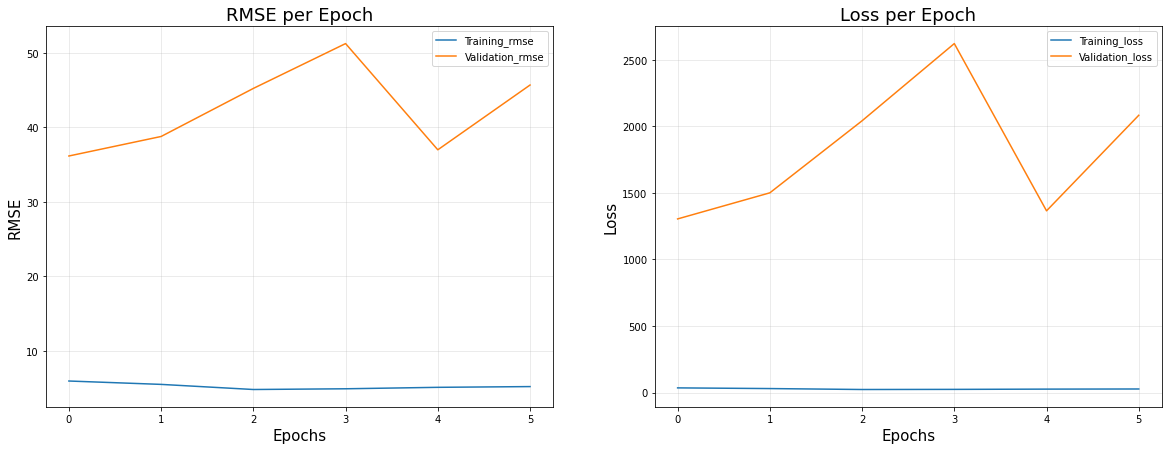

*****************************************************************************************************************

*****************************************************************************************************************

The number of epoch for this experiment is: 50
The Batch Size is: 64
Epoch 1/50
35/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 23.1477 - root_mean_squared_error: 4.8090
Epoch 1: val_loss improved from inf to 2092.00098, saving model to best_model_bidirectional_lstm_experiment.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 23.0006 - root_mean_squared_error: 4.7938 - val_loss: 2092.0010 - val_root_mean_squared_error: 45.7384
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 24.5198 - root_mean_squared_error: 4.9457
Epoch 2: val_loss did not improve from 2092.00098
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 24.4853 - root_mean_squared_error: 4.9423 - val_loss: 2974.3845 - val_root_mean_squared_error: 54.5379
Epoch 3/50
35/39 ━━━━━━━━━━━━━━━━

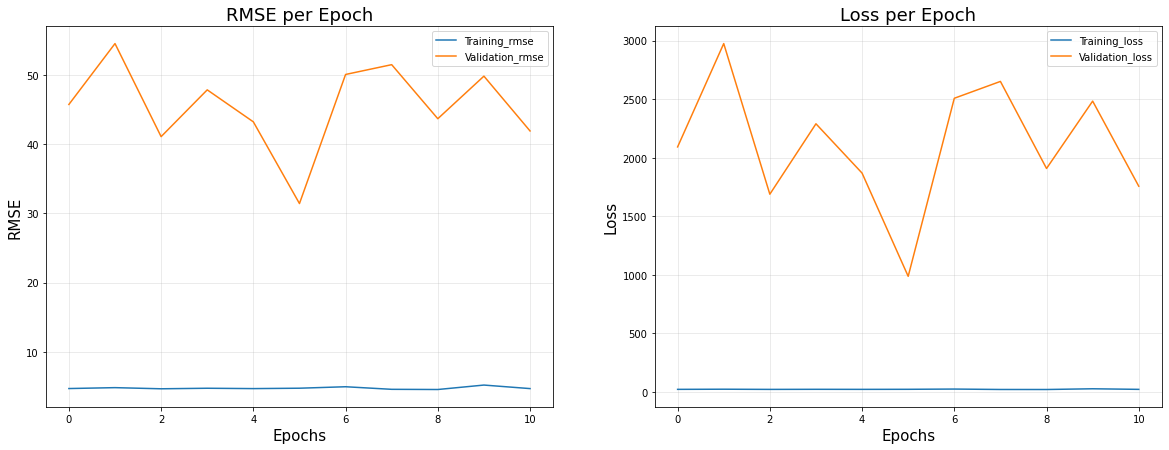

*****************************************************************************************************************

*****************************************************************************************************************

The number of epoch for this experiment is: 50
The Batch Size is: 128
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 22.8561 - root_mean_squared_error: 4.7766
Epoch 1: val_loss improved from inf to 3007.99585, saving model to best_model_bidirectional_lstm_experiment.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 22.8304 - root_mean_squared_error: 4.7741 - val_loss: 3007.9958 - val_root_mean_squared_error: 54.8452
Epoch 2/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 24.3203 - root_mean_squared_error: 4.9266
Epoch 2: val_loss improved from 3007.99585 to 1925.03198, saving model to best_model_bidirectional_lstm_experiment.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 24.1031 - root_mean_squared_error: 4.9045 - val_loss: 1925.0320 

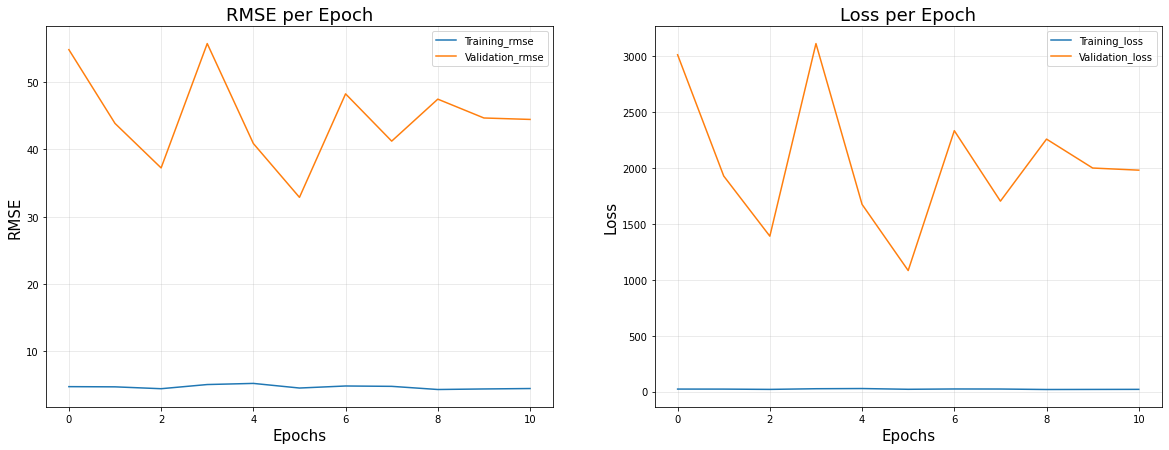

*****************************************************************************************************************

*****************************************************************************************************************

The number of epoch for this experiment is: 50
The Batch Size is: 256
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 19.0589 - root_mean_squared_error: 4.3648
Epoch 1: val_loss improved from inf to 2433.30029, saving model to best_model_bidirectional_lstm_experiment.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 19.0127 - root_mean_squared_error: 4.3595 - val_loss: 2433.3003 - val_root_mean_squared_error: 49.3285
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 21.2686 - root_mean_squared_error: 4.6078
Epoch 2: val_loss improved from 2433.30029 to 1738.72363, saving model to best_model_bidirectional_lstm_experiment.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 21.2306 - root_mean_squared_error: 4.6040 - val_loss: 1738.7236 

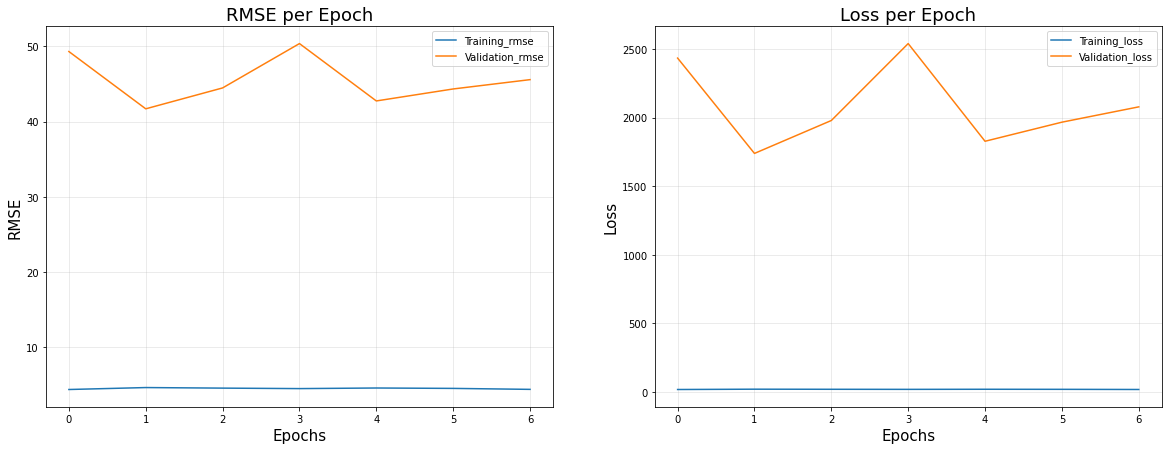

*****************************************************************************************************************

*****************************************************************************************************************

The number of epoch for this experiment is: 100
The Batch Size is: 32
Epoch 1/100
73/78 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 25.8248 - root_mean_squared_error: 5.0705
Epoch 1: val_loss improved from inf to 1944.04688, saving model to best_model_bidirectional_lstm_experiment.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 25.9411 - root_mean_squared_error: 5.0826 - val_loss: 1944.0469 - val_root_mean_squared_error: 44.0913
Epoch 2/100
77/78 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 32.8760 - root_mean_squared_error: 5.7130
Epoch 2: val_loss improved from 1944.04688 to 1786.36938, saving model to best_model_bidirectional_lstm_experiment.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 32.8695 - root_mean_squared_error: 5.7130 - val_loss: 1786.3694 -

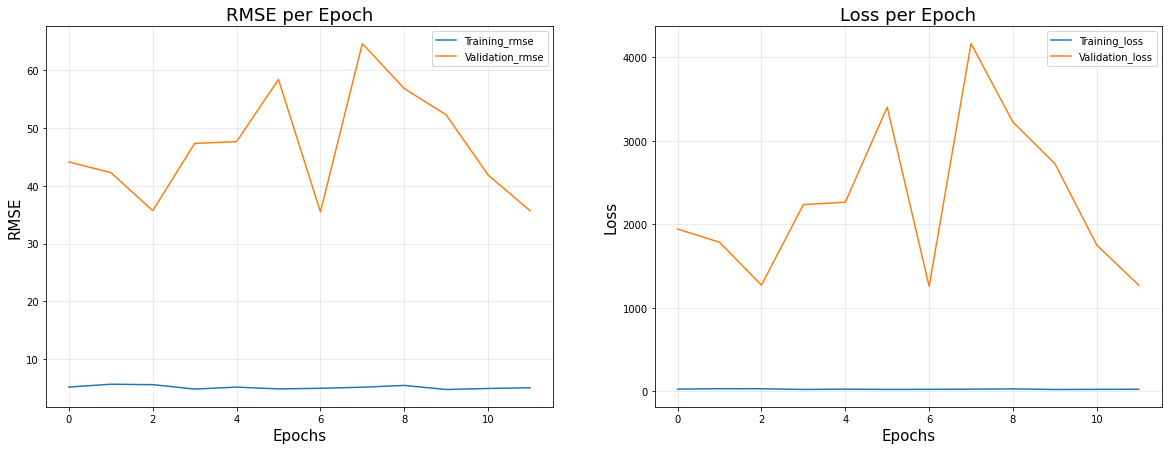

*****************************************************************************************************************

*****************************************************************************************************************

The number of epoch for this experiment is: 100
The Batch Size is: 64
Epoch 1/100
34/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 29.0002 - root_mean_squared_error: 5.3787
Epoch 1: val_loss improved from inf to 2356.67383, saving model to best_model_bidirectional_lstm_experiment.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 28.3799 - root_mean_squared_error: 5.3199 - val_loss: 2356.6738 - val_root_mean_squared_error: 48.5456
Epoch 2/100
38/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 23.9245 - root_mean_squared_error: 4.8875
Epoch 2: val_loss did not improve from 2356.67383
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 23.9247 - root_mean_squared_error: 4.8877 - val_loss: 2653.3813 - val_root_mean_squared_error: 51.5110
Epoch 3/100
36/39 ━━━━━━━━━━━━

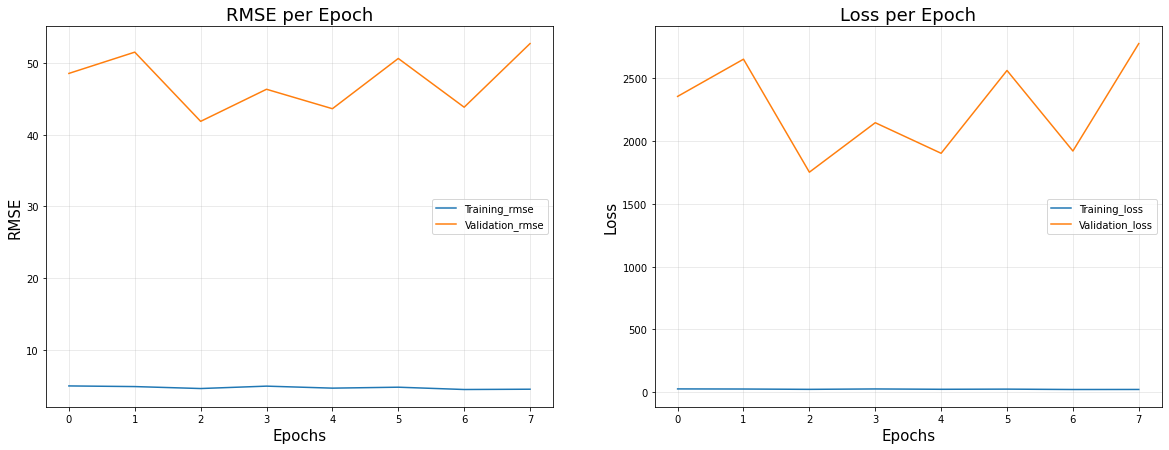

*****************************************************************************************************************

*****************************************************************************************************************

The number of epoch for this experiment is: 100
The Batch Size is: 128
Epoch 1/100
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 21.5909 - root_mean_squared_error: 4.6451
Epoch 1: val_loss improved from inf to 2368.01709, saving model to best_model_bidirectional_lstm_experiment.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 21.4103 - root_mean_squared_error: 4.6258 - val_loss: 2368.0171 - val_root_mean_squared_error: 48.6623
Epoch 2/100
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 16.6448 - root_mean_squared_error: 4.0766
Epoch 2: val_loss improved from 2368.01709 to 2125.55884, saving model to best_model_bidirectional_lstm_experiment.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 17.0514 - root_mean_squared_error: 4.1255 - val_loss: 2125.55

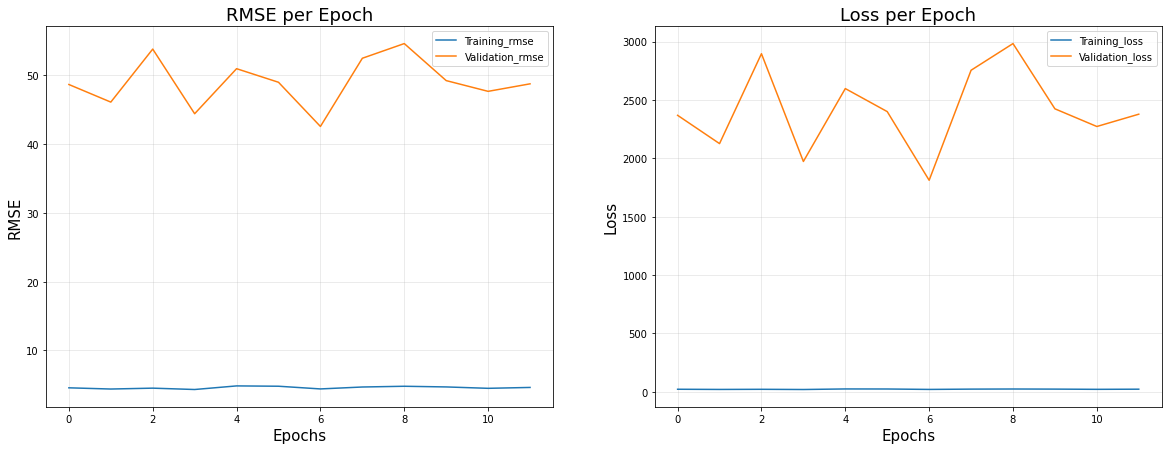

*****************************************************************************************************************

*****************************************************************************************************************

The number of epoch for this experiment is: 100
The Batch Size is: 256
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 20.0606 - root_mean_squared_error: 4.4733
Epoch 1: val_loss improved from inf to 2237.87329, saving model to best_model_bidirectional_lstm_experiment.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 19.9447 - root_mean_squared_error: 4.4607 - val_loss: 2237.8733 - val_root_mean_squared_error: 47.3062
Epoch 2/100
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 18.7215 - root_mean_squared_error: 4.3252
Epoch 2: val_loss improved from 2237.87329 to 2211.52393, saving model to best_model_bidirectional_lstm_experiment.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 18.6783 - root_mean_squared_error: 4.3206 - val_loss: 2211.52

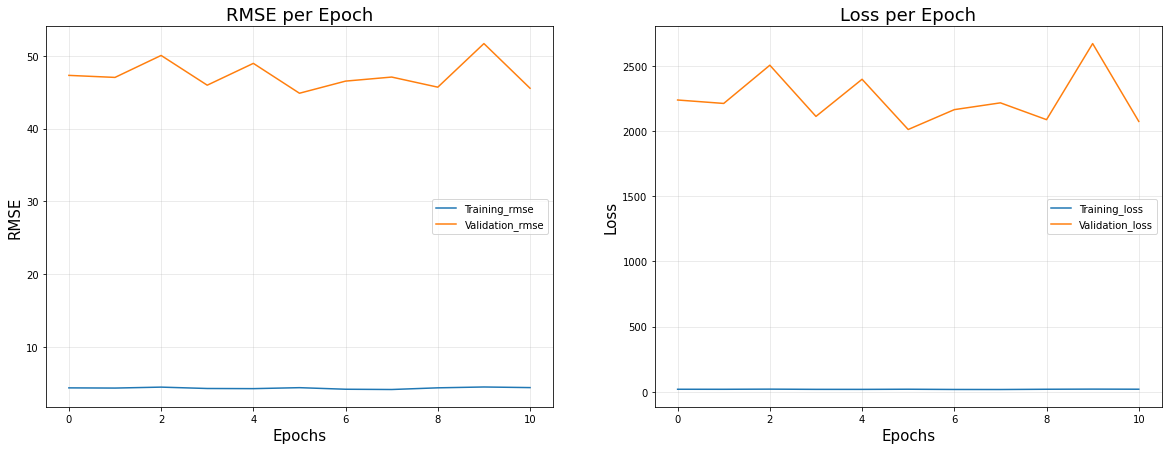

In [72]:
epochs=[10,20,50,100]
batch_sizes = [32,64,128,256]
for epoch in epochs:
    for batch_size in batch_sizes:  
        
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        mc = ModelCheckpoint('best_model_bidirectional_lstm_experiment.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        # fit model
        print('*****************************************************************************************************************')
        print()
        print('*****************************************************************************************************************')
        print()
        print('The number of epoch for this experiment is:',epoch)
        print('The Batch Size is:',batch_size)
        Lstm_Bidirectional_Model_history = Lstm_bidirectional_model.fit(X_train, y_train, validation_split=0.3,
                                                                  epochs=epoch, batch_size=batch_size, callbacks=[es,mc])
        
        
        print()
        print('****************************************************************************************************************')
        print('The metrics score for epoch: {0}\nBatch Size: {1}\nRMSE for training set: {2}\nRMSE forValidation set: {3}\nLoss for Training set: {4}\nLoss for Validation set: {5}'
              .format(epoch,batch_size,mean(Lstm_Bidirectional_Model_history.history['root_mean_squared_error']),
        mean(Lstm_Bidirectional_Model_history.history['val_root_mean_squared_error']),
        mean( Lstm_Bidirectional_Model_history.history['loss']),mean(Lstm_Bidirectional_Model_history.history['val_loss'])))
        
       
        
        print('*****************************************************************************************************************')
        print()
        print('*****************************************************************************************************************')
        print()
        print('Comparative plot for RMSE per epoch and Loss per epoch for training and validation sets')
        print('*****************************************************************************************************************')
        print()
        
       
        
        
        fig = plt.figure(figsize=(20,7))
        fig.add_subplot(121)

        # RMSE per Epoch
        plt.plot(Lstm_Bidirectional_Model_history.epoch, Lstm_Bidirectional_Model_history.history['root_mean_squared_error'], label = "Training_rmse")
        plt.plot(Lstm_Bidirectional_Model_history.epoch, Lstm_Bidirectional_Model_history.history['val_root_mean_squared_error'], label = "Validation_rmse")

        plt.title("RMSE per Epoch", fontsize=18)
        plt.xlabel("Epochs", fontsize=15)
        plt.ylabel("RMSE", fontsize=15)
        plt.grid(alpha=0.3)
        plt.legend()


        #Adding Subplot 1 (For Loss)
        fig.add_subplot(122)

        plt.plot(Lstm_Bidirectional_Model_history.epoch, Lstm_Bidirectional_Model_history.history['loss'], label="Training_loss")
        plt.plot(Lstm_Bidirectional_Model_history.epoch, Lstm_Bidirectional_Model_history.history['val_loss'], label="Validation_loss")

        plt.title("Loss per Epoch", fontsize=18)
        plt.xlabel("Epochs", fontsize=15)
        plt.ylabel("Loss", fontsize=15)
        plt.grid(alpha=0.3)
        plt.legend()

        plt.show()

# Comparing the Baseline Model and Experiment Model

# Hyperparameter Tunning

In [73]:
#This is in contrast to the tuner approach where options for hyper parameters “hp” are specified and passed to the model

def build_model(hp):
    model = Sequential()

    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(Bidirectional(LSTM(hp.Int('input_unit'+ str(i),min_value=16,max_value=128,step=16),activation='relu',return_sequences=True)))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Bidirectional(LSTM(hp.Int('input_unit'+ str(i),min_value=16,max_value=128,step=16),activation='relu', return_sequences=False)))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(1))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    import keras
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model
    
tuner= kt.RandomSearch(
    hypermodel=build_model,
    objective=kt.Objective("val_loss", direction="min"),
    max_trials=3,
    executions_per_trial=3,
    overwrite=True,
    directory="LSTM_search",
    project_name="Search_result"
    )  


In [74]:
epoch=10
batch_size=64
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)       

file_path = 'best_model_lstm_selected.keras'

mc = tf.keras.callbacks.ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
tuner.search(
        x=X_train,
        y=y_train,
        epochs=epoch,
        batch_size=batch_size,
        validation_data=(X_train,y_train),validation_split=0.3, callbacks=[stop_early,mc]
)

Trial 3 Complete [00h 01m 59s]
val_loss: 37.505235036214195

Best val_loss So Far: 37.505235036214195
Total elapsed time: 00h 05m 33s


In [75]:
tuner.results_summary()

Results summary
Results in LSTM_search\Search_result
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 2 summary
Hyperparameters:
num_layers: 8
input_unit0: 32
input_unit1: 32
Dropout_rate: 0.1
lr: 0.001016299698927462
input_unit2: 16
input_unit3: 128
input_unit4: 16
input_unit5: 16
input_unit6: 112
input_unit7: 16
Score: 37.505235036214195

Trial 0 summary
Hyperparameters:
num_layers: 7
input_unit0: 128
input_unit1: 32
Dropout_rate: 0.2
lr: 0.004331626142464494
input_unit2: 16
input_unit3: 16
input_unit4: 16
input_unit5: 16
input_unit6: 16
Score: 96.01401011149089

Trial 1 summary
Hyperparameters:
num_layers: 8
input_unit0: 112
input_unit1: 32
Dropout_rate: 0.4
lr: 0.0022132225207133274
input_unit2: 16
input_unit3: 48
input_unit4: 32
input_unit5: 96
input_unit6: 96
input_unit7: 16
Score: 568.0335184733073


In [77]:
best_lstm_model = tf.keras.models.load_model('best_model_lstm_selected.keras')
best_lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 3, 64)          │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 3, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 3, 32)          │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 3, 256)         │       164,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 3, 32)          │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 3, 32)          │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 3, 224)         │       129,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 3, 32)          │        30,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,251,173 (4.77 MB)

 Trainable params: 417,057 (1.59 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 834,116 (3.18 MB)

# Predictions 


In [78]:
from keras.models import load_model
# Load the saved model
result_Selected_model  = best_lstm_model.evaluate(X_test, y_test)
print("Loss for implemented model:", result_Selected_model[0])

# print("Test MAE for multi-layer baseline model:", result_Selected_model[1])

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 10.8643 - root_mean_squared_error: 3.2114
Loss for implemented model: 7.255719184875488


In [79]:
result_Selected_model

[7.255719184875488, 2.6936442852020264]

In [80]:
X_test.shape

(892, 3, 1)

In [81]:
model=best_lstm_model
company='Yes Bank Ltd'

# Prediction
y_pred = model.predict(X_test)

# We create a dataframe from y_pred to have date-time indexes.
pred_data = pd.DataFrame(y_pred[:,0], dates_test,columns=['Close'])




28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step


In [82]:
# We create a dataframe from y_pred to have date-time indexes.
pred_data = pd.DataFrame(y_pred[:,0], index=dates_test,columns=['Predicted_close_price'])
y_test_df = pd.DataFrame(y_test, columns = ['Actual_close_price'], index = dates_test)
df_plot=pd.merge(y_test_df,pred_data, on=[dates_test])
df_plot_actual=df_plot.rename(columns={'key_0':'Date'})
df_plot_actual.set_index('Date',inplace=True)
df=df_plot_actual

df.head()

,Actual_close_price,Predicted_close_price
Date,,
2020-01-03 00:00:00+05:30,46.049999,41.851696
2020-01-06 00:00:00+05:30,47.299999,41.910389
2020-01-07 00:00:00+05:30,44.750000,42.851982
2020-01-08 00:00:00+05:30,42.099998,42.213326
2020-01-09 00:00:00+05:30,38.549999,40.381470


In [83]:
df.tail()

,Actual_close_price,Predicted_close_price
Date,,
2023-07-31 00:00:00+05:30,17.000000,19.999840
2023-08-01 00:00:00+05:30,16.950001,20.005266
2023-08-02 00:00:00+05:30,16.900000,19.954948
2023-08-03 00:00:00+05:30,16.850000,19.914621
2023-08-04 00:00:00+05:30,16.950001,19.860086


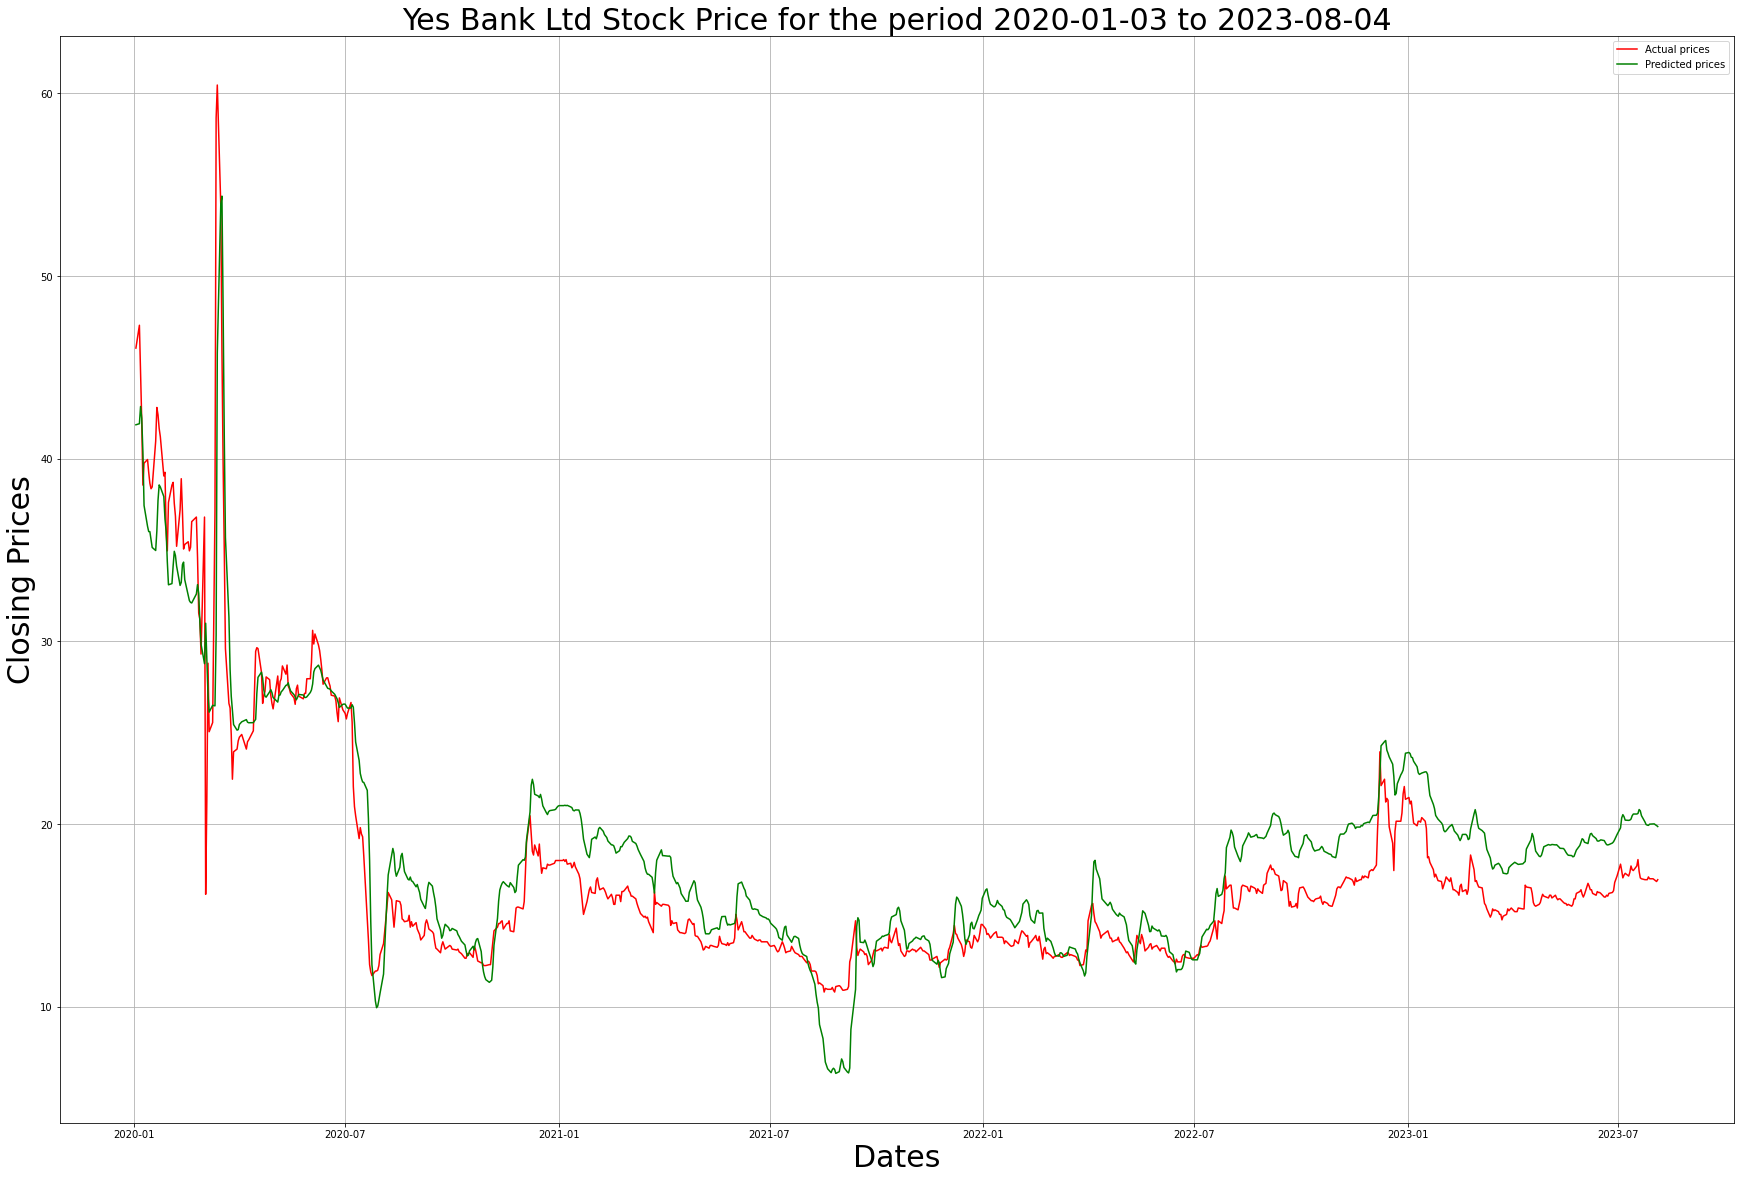

In [84]:
# Take the square, and the exponent
#pred_data = pred_data.apply(np.square)
#pred_data = pred_data.apply(np.exp)


# Plot actual prices vs predicted prices 
plt.figure(figsize=(30,20))
plt.grid(True)
plt.xlabel('Dates',fontsize = 30)
plt.ylabel('Closing Prices',fontsize = 30)
plt.plot(df['Actual_close_price'],'r',label='Actual prices')
plt.plot(df['Predicted_close_price'], 'g',label='Predicted prices')
plt.title(company + ' Stock Price for the period 2020-01-03 to 2023-08-04',fontsize = 30)

plt.legend(loc=0)